Script overview: 
1. Block 1 of the script imports AT domains from files in "route" and combines with substrate labels generated from file "labels_sheet"
2. Block 2 generates graph networks from carbon alphas using a k-nearest neighbour method. Features are supplied as a OHE of amino acid type. Labels are unified in the graph constructor as graph_y.
3. Block 3 is a dataloader. AT substrate type is balanced in this block for Train, Validation and Test data.
4. Block 4 contains the GNN model, training loop and test step.
5. Block 5 requires a single AT domain .pdb in a unique folder. The structure is converted to a graph and run through a dataloader. The loader is passed to an explainer, which outputs two graphs: most important features (amino acid OHE) and a networkX map, which shows sub graph structures.
6. Block 6 is a loop that explains each graph in the test data partition
7. Block 7 tests structures from the catalytic inversion data set
8. Block 8 test Graph attention networks

In [1]:
### Import pdb files and labels -> prepare for graph creation ###
import os
import torch
import graphein
import pandas as pd
import re

## Import pdb files ##
# File path to AT domain .pdb files # 
route = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/Aligned_big_set3_SNAKELESS/"


# Get a list of filenames in the pdb folder "route" #
filenames = os.listdir(route)

# Create a list of absolute file paths in route # 
absolute_file_paths = [os.path.join(route, filename) for filename in filenames]

## Import labels from file and create a dataframe matched to pdb files ##
# Import substrate sheet and create OHE for mal and mmal # 
labels_sheet= pd.read_csv("/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Webscraping/ClusterCAD Webscraping/20230713_AT_SMILES_unified_full_corrections.csv")
selected_columns = ['Gene', 'AT_substrate']
labels_sheet = labels_sheet[selected_columns]

# Create a new DataFrame with one-hot encoded "AT_substrate" names
ohe_substrate = pd.get_dummies(labels_sheet['AT_substrate'])

# Concatenate the OHE DataFrame with the original DataFrame
ohe_labels_sheet = pd.concat([labels_sheet, ohe_substrate], axis=1)

# Drop the original "AT_substrate" column
ohe_labels_sheet = ohe_labels_sheet.drop(columns=['AT_substrate'])
selected_columns = ['Gene','mal', 'mmal']
labels=ohe_labels_sheet[selected_columns]

# Extract gene names from file names
gene_names = [re.match(r'(.+)\.', os.path.splitext(os.path.basename(path))[0]).group(1) for path in absolute_file_paths]

# Filter labels for the matched gene names
matched_labels = labels[labels.iloc[:, 0].isin(gene_names)].set_index(labels.columns[0])

# Create a list of gene names from the absolute file paths
file_path_gene_names = [re.match(r'(.+)\.', os.path.splitext(os.path.basename(path))[0]).group(1) for path in absolute_file_paths]

# Reorder matched_labels to match the order of absolute_file_paths
reordered_labels = matched_labels.loc[file_path_gene_names]

# Add paths # 
reordered_labels["paths"] = absolute_file_paths

## Rebalance mal to equal mmal ## 
# calculate difference between mal and mmal (assumes mal always higher than mmal) # 
mal_total = sum(reordered_labels['mal'])
print("mal:", mal_total) 
mmal_total = sum(reordered_labels['mmal'])
print("mmal:", mmal_total)
mal_dump = mal_total - mmal_total

# Randomly remove mal items to rebalance #
mal_rows = reordered_labels[reordered_labels['mal'] == 1]
random_sample = mal_rows.sample(n=mal_dump)
sampled_indices = random_sample.index
balanced_reordered_labels = reordered_labels.drop(sampled_indices)

# Check number is corrected #
mal_total = sum(balanced_reordered_labels['mal'])
print("New_mal:", mal_total) 
mmal_total = sum(balanced_reordered_labels['mmal'])
print("New_mmal:", mmal_total)

# Create the graph_label_map dictionary from the balanced_reordered_labels table
balanced_reordered_labels2 = balanced_reordered_labels.drop('paths', axis=1)

# This creates a binary Mal not mal (mmal) classification (i.e. it's either mal or its not). You need to work out why the graphs loader won't take multidimentional tensors#
#balanced_reordered_labels2 = balanced_reordered_labels2.drop('mal', axis=1)
graph_label_map = balanced_reordered_labels2.to_dict(orient='index')

print("Import done")


import pandas as pd
# Check if all row names (index) are unique
are_row_names_unique = balanced_reordered_labels2.index.is_unique

if are_row_names_unique:
    print("All row names (index) are unique.")
else:
    print("There are duplicate row names (index).")




mal: 481
mmal: 307
New_mal: 307
New_mmal: 307
Import done
All row names (index) are unique.


[05/20/24 14:14:10] WARNING  To use the Graphein submodule                                         ]8;id=640771;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=400685;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py#44\44]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             biovec cannot be installed via conda                                                  
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

[05/20/24 14:14:11] WARNING  To use the Graphein submodule graphein.protein.visualisation, you  ]8;id=490808;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/visualisation.py\visualisation.py]8;;\:]8;id=478584;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/visualisation.py#35\35]8;;\
                             need to install: pytorch3d                                                            
                             To do so, use the following command: conda install -c pytorch3d                       
                             pytorch3d                                                                             

Output()

/home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py:160: FutureWarning: The default 
value of regex will change from True to False in a future version.
  df["node_id"] = df["node_id"].str.replace(":$", "")

/home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py:163: FutureWarning: The default 
value of regex will change from True to False in a future version.
  df["node_id"] = df["node_id"].str.replace(":$", "")

                    DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=408932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=600822;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py#186\186]8;;\

                    DEBUG    Detected 298 total nodes                                                 ]8;id=440840;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=762630;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py#438\438]8;;\

                    INFO     Found: 894 KNN edges                                                  ]8;id=451402;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=997042;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/edges/distance.py#1130\1130]8;;\

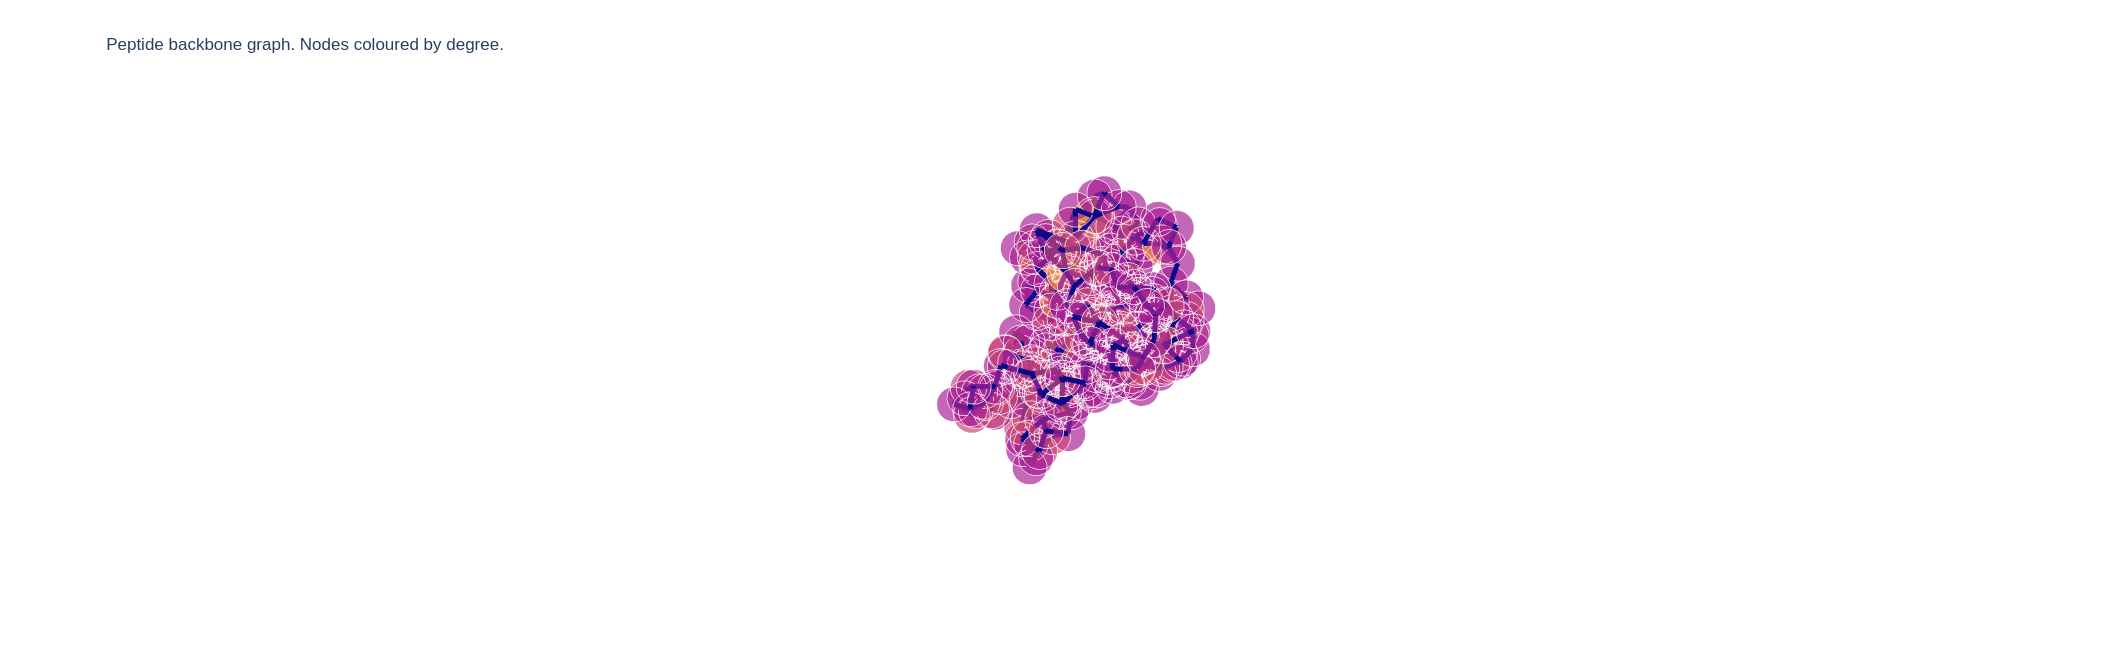

done
ProteinGraphDataset(614)
614


In [2]:
### Graph Creation methods: ###
## 4. K nearest neighbours ##
from functools import partial
from graphein.protein.edges.distance import add_k_nn_edges
from graphein.protein.features.nodes.amino_acid import amino_acid_one_hot
from graphein.protein.visualisation import plotly_protein_structure_graph
from graphein.protein.graphs import construct_graph

new_edge_funcs = {"edge_construction_functions": [partial(add_k_nn_edges, k=3, long_interaction_threshold=0)],
                  "node_metadata_functions": [amino_acid_one_hot]
                  }
config = graphein.protein.ProteinGraphConfig(**new_edge_funcs)

g = construct_graph(config=config, path=absolute_file_paths[0])

p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="degree",
    label_node_ids=False,
    plot_title="Peptide backbone graph. Nodes coloured by degree.",
    node_size_multiplier=1
    )
p.show()

### Create an in-file dataset for passing to pytorch geometric ###
## Note: this can take a while. If the dataset already exists it won't be regenerated ##
from graphein.ml import GraphFormatConvertor, ProteinGraphDataset

# list of columns included in nx ==> pyg conversion #
info_list = ["edge_index", 
             "amino_acid_one_hot",
             "node_id", 
             "chain_id", 
             "residue_name", 
             "residue_number", 
             "atom_type", 
             "element_symbol",
             "coords",
             "b_factor", 
             "kind", 
             "name",
             "chain_ids"]

# NetworkX to PyG conversion #
convertor= GraphFormatConvertor(src_format = "nx", 
                                dst_format = "pyg", 
                                verbose = "all_info", 
                                columns = info_list
                               )

# Convert the graph_label_map dictionary to a list of tensors # 
graph_labels_list = [torch.tensor(list(label.values())) for label in graph_label_map.values()]

# Convert paths to a list of paths
paths_list=balanced_reordered_labels['paths'].tolist()
# Create the dataset with graph_labels as a list of tensors #
dataset = ProteinGraphDataset(
    root='/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20231204_AT_graphs_Ca_balanced_k_nearest3', 
    paths=paths_list,
    graphein_config=config, 
    graph_labels=graph_labels_list,
    graph_format_convertor=convertor,
    num_cores=7
)

print("done")

print(dataset)
print(len(graph_labels_list))

In [3]:
from sklearn.model_selection import train_test_split
### Data loaders ### 
from torch_geometric.data import Data, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the dataset into training, validation, and test sets #
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 64

# Define your custom Data class with __cat_dim__ method
class MyData(Data):
    def __cat_dim__(self, key, value, *args, **kwargs):
        if key == 'graph_y':
            return None  # Indicates that 'graph_y' should be batched along a new dimension
        return super().__cat_dim__(key, value, *args, **kwargs)

# Create a list of Data objects, ensuring 'graph_y' is a 2D tensor [num_examples, num_labels]
# Initialize an empty list to store the modified Data objects
data_list = []

# Iterate through your existing ProteinGraphDataset
for graph in dataset:
    # Create a new Data object
    data = Data(
        edge_index = graph.edge_index, 
        node_id = graph.node_id,
        coords = graph.coords, 
        name = graph.name,
        num_nodes = graph.num_nodes,
        graph_y = graph.graph_y.view(1, 2), 
        x=graph.amino_acid_one_hot.view(len(graph.node_id), 20),
    )
    # Append the modified Data object to the list
    data_list.append(data)




# Extract labels from your data_list
labels = [data.graph_y.tolist()[0] for data in data_list]

# Split the data into training, validation, and test sets with stratified sampling
train_data, test_data, train_labels, test_labels = train_test_split(data_list, labels, test_size=test_ratio, random_state=42, stratify=labels)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=val_ratio/(1-test_ratio), random_state=42, stratify=train_labels)

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

print("Train_set:", len(train_loader.dataset))
print("Val_set:", len(val_loader.dataset))
print("Test_set:", len(test_loader.dataset))

def count_labels(loader):
    mal_count = 0
    mmal_count = 0
    total_count = 0
    
    for batch in loader:
        # Extract labels from the batch
        labels = batch.graph_y.squeeze().tolist()
        
        # Count mal and mmal labels in the batch
        mal_count += labels.count([1, 0])  # Assuming [1, 0] represents 'mal'
        mmal_count += labels.count([0, 1])  # Assuming [0, 1] represents 'mmal'
        total_count += len(labels)
    
    return mal_count, mmal_count, total_count

# Calculate label composition for each loader
train_mal, train_mmal, train_total = count_labels(train_loader)
val_mal, val_mmal, val_total = count_labels(val_loader)
test_mal, test_mmal, test_total = count_labels(test_loader)

# Print the results
print("Training Set Composition:")
print(f"Mal: {train_mal} samples, Mmal: {train_mmal} samples, Total: {train_total} samples")
print(f"Mal Ratio: {train_mal/train_total: %}, Mmal Ratio: {train_mmal/train_total:%}")

print("\nValidation Set Composition:")
print(f"Mal: {val_mal} samples, Mmal: {val_mmal} samples, Total: {val_total} samples")
print(f"Mal Ratio: {val_mal/val_total:%}, Mmal Ratio: {val_mmal/val_total:%}")

print("\nTest Set Composition:")
print(f"Mal: {test_mal} samples, Mmal: {test_mmal} samples, Total: {test_total} samples")
print(f"Mal Ratio: {test_mal/test_total:%}, Mmal Ratio: {test_mmal/test_total:%}")

Train_set: 490
Val_set: 62
Test_set: 62
Training Set Composition:
Mal: 245 samples, Mmal: 245 samples, Total: 490 samples
Mal Ratio:  50.000000%, Mmal Ratio: 50.000000%

Validation Set Composition:
Mal: 31 samples, Mmal: 31 samples, Total: 62 samples
Mal Ratio: 50.000000%, Mmal Ratio: 50.000000%

Test Set Composition:
Mal: 31 samples, Mmal: 31 samples, Total: 62 samples
Mal Ratio: 50.000000%, Mmal Ratio: 50.000000%


DataBatch(x=[18735, 20], edge_index=[2, 32340], node_id=[64], coords=[18735, 3], name=[64], num_nodes=18735, graph_y=[64, 2], batch=[18735], ptr=[65])
Epoch [1/70] - Train Loss: 0.6941 - Train Accuracy: 0.4714 - Train AUC: 0.5025 - Validation Loss: 0.6916 - Validation Accuracy: 0.5000 - Validation AUC: 0.7367
Epoch [2/70] - Train Loss: 0.6912 - Train Accuracy: 0.5143 - Train AUC: 0.6078 - Validation Loss: 0.6904 - Validation Accuracy: 0.5000 - Validation AUC: 0.8325
Epoch [3/70] - Train Loss: 0.6904 - Train Accuracy: 0.5143 - Train AUC: 0.5797 - Validation Loss: 0.6891 - Validation Accuracy: 0.5000 - Validation AUC: 0.8783
Epoch [4/70] - Train Loss: 0.6883 - Train Accuracy: 0.5102 - Train AUC: 0.8011 - Validation Loss: 0.6877 - Validation Accuracy: 0.5968 - Validation AUC: 0.9136
Epoch [5/70] - Train Loss: 0.6862 - Train Accuracy: 0.8082 - Train AUC: 0.9131 - Validation Loss: 0.6862 - Validation Accuracy: 0.7419 - Validation AUC: 0.9490
Epoch [6/70] - Train Loss: 0.6865 - Train Accurac

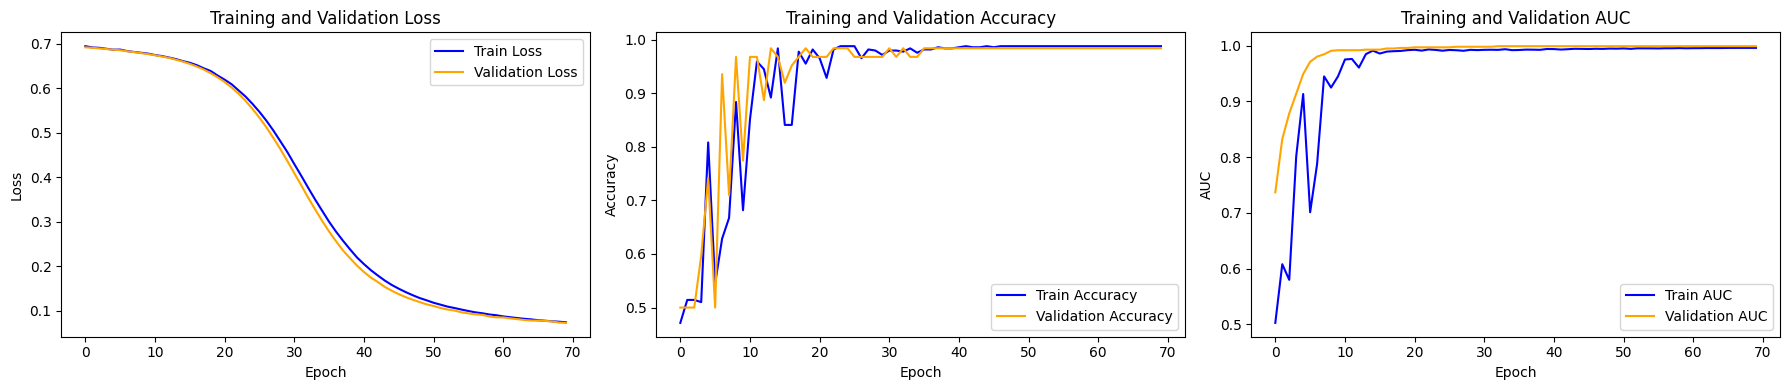

Training finished!
Test Accuracy: 0.9839
Test AUC: 0.9844


In [14]:
### This version's model takes in tensors instead of "data". This is needed to talk to the graph explainer. ###
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set seed
torch.manual_seed(15706112877486103401)

# Network parameters
input_dim = 20  # Corresponds to amino acid OHE
hidden_dim = 64
output_dim = 2  # Output dimension for binary classification.

# Hyperparameters
num_epochs = 70
learning_rate = 0.001

# Define a GNN model
class MyGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        # Convert input tensor 'x' to Float data type
        x = x.float()
        
        # Apply the first graph convolution layer
        x = self.conv1(x, edge_index)
        x = x.relu()
    
        # Apply the second graph convolution layer
        x = self.conv2(x, edge_index)
        x = x.sigmoid()
    
        # Perform graph-level pooling (e.g., global max pooling)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        x = torch.relu(x)  # Sigmoid activation for binary classification
    
        return x


# Initialize your GNN model
model = MyGNN(input_dim, hidden_dim, output_dim)

# Define batching
batch = next(iter(train_loader))
print(batch)

# Forward pass through the model
out = model(batch.x, batch.edge_index, batch.batch)

# Define optimization method
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Empty containers for loss and accuracy metrics
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

train_aucs = []  # New list to store training AUC values
val_aucs = []  # New list to store validation AUC values

## Training and validation loops ##
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0
    train_predictions = []  # New list to store training predictions
    train_labels_all = []  # New list to store true training labels
    
    # Training loop
    model.train()
    train_correct_count = 0  # Total number of correct predictions for the epoch
    train_total_count = 0  # Total number of samples for the epoch
    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Compute loss
        loss = F.cross_entropy(out, labels, reduction='sum')
        epoch_train_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        predicted_labels = out.argmax(dim=1)
        train_correct_count += (predicted_labels == labels).sum().item()
        train_total_count += labels.size(0)
        
        # Store predictions and true labels for each batch
        train_predictions.extend(out[:, 1].detach().cpu().numpy())  # Detach the tensor before converting to numpy
        train_labels_all.extend(labels.detach().cpu().numpy())
    
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # Calculate training accuracy
    train_accuracy = train_correct_count / train_total_count
    train_accuracies.append(train_accuracy)
    
    # Calculate AUC-ROC for training data
    train_auc = roc_auc_score(train_labels_all, train_predictions)
    train_aucs.append(train_auc)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    total_correct_val = 0
    total_samples_val = 0
    val_predictions = []  # New list to store predictions
    val_labels_all = []  # New list to store true labels
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
    
            labels = (batch.graph_y[:, 0] == 1).long()
    
            loss = F.cross_entropy(out, labels, reduction='sum')
            val_loss += loss.item()
    
            predicted_labels = out.argmax(dim=1)
            total_correct_val += (predicted_labels == labels).sum().item()
            total_samples_val += labels.size(0)
    
            # Store predictions and true labels for each batch
            val_predictions.extend(out[:, 1].cpu().numpy())  # Detach not needed for no_grad context
            val_labels_all.extend(labels.cpu().numpy())
    
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    
    # Calculate overall validation accuracy using all true labels
    val_accuracy = total_correct_val / total_samples_val
    val_accuracies.append(val_accuracy)
    
    # Calculate AUC-ROC for validation data
    val_auc = roc_auc_score(val_labels_all, val_predictions)
    val_aucs.append(val_auc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Train AUC: {train_auc:.4f} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation AUC: {val_auc:.4f}")

# Plotting the training progress
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_aucs, label='Train AUC', color='blue')
plt.plot(val_aucs, label='Validation AUC', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished!")

### Test data ###
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score

# Assuming you have your test data in a DataLoader called test_loader
# If you don't have one, create it similarly to how you created train_loader and val_loader.

# Set the model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
total_correct_test = 0
total_samples_test = 0

# Lists to store predictions and true labels for potential further analysis
test_predictions = []
test_labels = []
test_probabilities = []  # New list to store probabilities for AUC

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)  # Send data to GPU if available
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Calculate predictions
        predicted_labels = out.argmax(dim=1)
        
        # Accumulate the number of correct predictions and total samples
        total_correct_test += (predicted_labels == labels).sum().item()
        total_samples_test += labels.size(0)

        # Store predictions and true labels
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probabilities.extend(out[:, 1].cpu().numpy())  # Store the probabilities for the positive class

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)

# Calculate test AUC
test_auc = roc_auc_score(test_labels, test_probabilities)

# Report the test accuracy and AUC
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")


DataBatch(x=[281, 20], edge_index=[2, 490], node_id=[1], coords=[281, 3], name=[1], num_nodes=281, batch=[281], ptr=[2])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 3.4356e-11, 0.0000e+00,
        2.6362e-11, 3.4465e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1

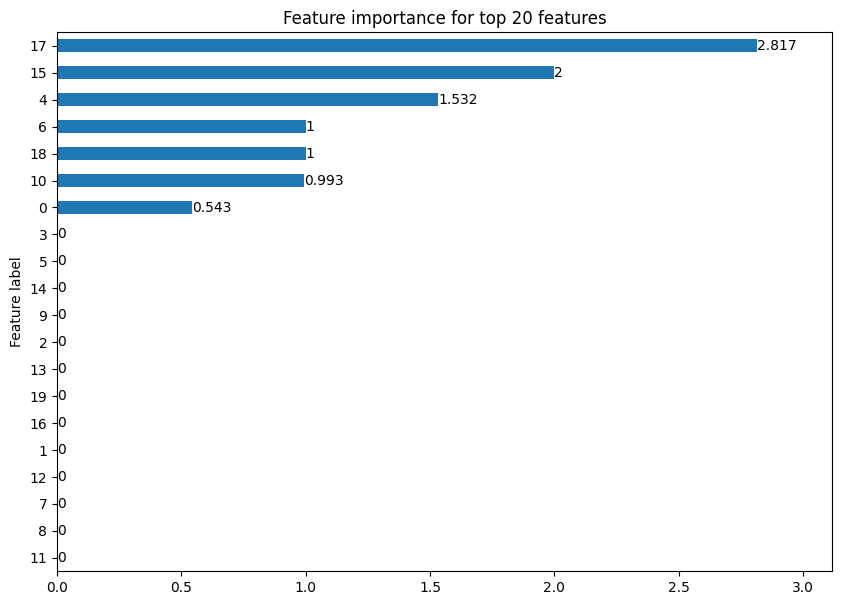

In [13]:
import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
import pandas as pd

## Input needs to be a 
single_file = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/test_file/"
#single_file = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/test_file_mal/"

filenames = os.listdir(single_file)
absolute_file_paths_explainer = [os.path.join(single_file, filename) for filename in filenames]

# Create the dataset with graph_labels as a list of tensors
dataset_explainer = ProteinGraphDataset( 
    root='/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/test_graph', 
    paths=absolute_file_paths_explainer,
    graphein_config=config, 
    graph_format_convertor=convertor,
    num_cores=7
)

# Define your custom Data class with __cat_dim__ method
class MyData(Data):
    def __cat_dim__(self, key, value, *args, **kwargs):
        if key == 'graph_y':
            return None  # Indicates that 'graph_y' should be batched along a new dimension
        return super().__cat_dim__(key, value, *args, **kwargs)

# Create a list of Data objects, ensuring 'graph_y' is a 2D tensor [num_examples, num_labels]
# Initialize an empty list to store the modified Data objects
data_list_explainer = []

# Iterate through your existing ProteinGraphDataset
for graph in dataset_explainer:
    # Create a new Data object
    data = Data(
        edge_index=graph.edge_index, 
        node_id=graph.node_id,
        coords=graph.coords, 
        name=graph.name,
        num_nodes=graph.num_nodes,
        x=graph.amino_acid_one_hot.view(len(graph.node_id), 20),
    )
    # Append the modified Data object to the list
    data_list_explainer.append(data)

explain_loader = DataLoader(data_list_explainer, batch_size=batch_size)



from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
import torch

# The first graph is in the first batch
loader = explain_loader

#loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Create an instance of your MyGNN model
#model = MyGNN(input_dim, hidden_dim output_dim),


explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100000),
    explanation_type='phenomenon', # options are model (describes the model) or phenomenon (describes why descision was made for input and input label)
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw', 
    ),
)

# Generate explanation for the node at index `10`:
for batch in loader:
    print(batch)
    print(batch.x)
    target_values = [1,0]  # Replace with batch.graph_y for loaders with labels attached. [1,0]=mmal [0,1]=mal
    target = torch.tensor(target_values).long()
    explanation = explainer(x=batch.x, edge_index=batch.edge_index, batch=batch.batch, target=target)
    print(explanation.edge_mask)
    print(explanation.node_mask)

explanation.visualize_feature_importance(top_k=20) #feat_labels = Union[List[str], NoneType]
explanation.visualize_graph(backend = "graphviz")




#Total: DataBatch(edge_index=[2, 31432], node_id=[62], coords=[18213, 3], name=[62], num_nodes=18213, graph_y=[62, 2], amino=[18213, 20], batch=[18213], ptr=[63])

Processing batch with 62 graphs
Explanation for graph AceP2_Mod.3.pdb_aligned: tensor([3.5630e-11, 0.0000e+00, 0.0000e+00, 3.5231e-11, 0.0000e+00, 0.0000e+00,
        3.5434e-11, 0.0000e+00, 3.5456e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 3.5451e-11, 8.5398e-11, 0.0000e+00, 0.0000e+00,
        8.4827e-11, 0.0000e+00, 3.5532e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.5862e-11, 0.0000e+00, 0.0000e+00, 3.5998e-11, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+0

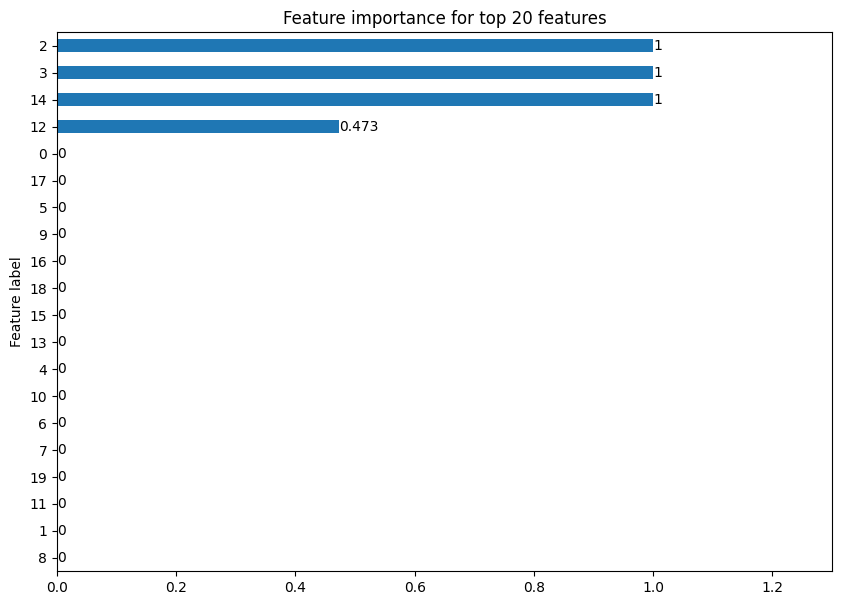

Explanation for graph pimS1_Mod.2.pdb_aligned: tensor([7.0627e-01, 0.0000e+00, 0.0000e+00, 4.0590e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.4993e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.3655e-11,
        6.4403e-11, 1.0000e+00, 0.0000e+00, 4.3612e-11, 0.0000e+00, 0.0000e+00,
        4.3890e-11, 2.3639e-01, 0.0000e+00, 4.0629e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0636e-11, 4.0714e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0472e-11, 0.0000e+00, 0.000

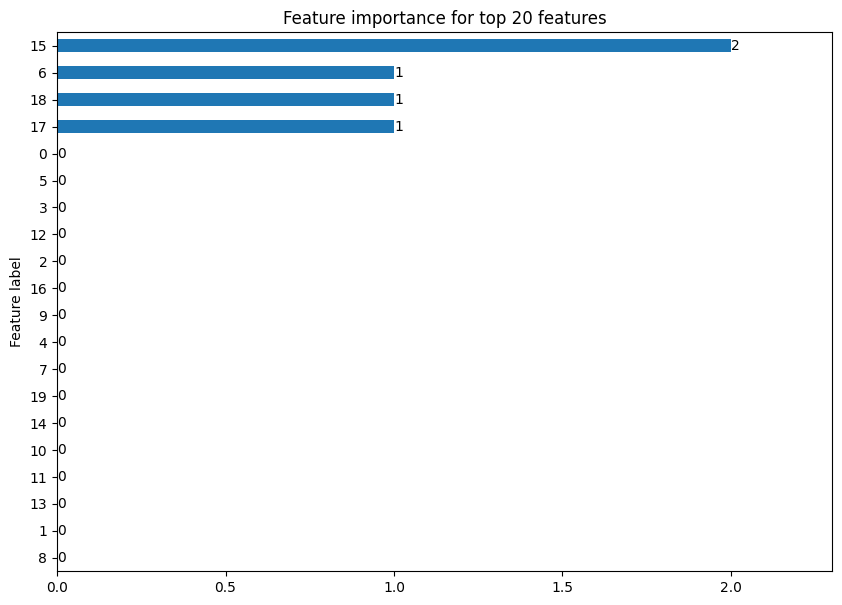

Explanation for graph nanA2_Mod.1.pdb_aligned: tensor([5.2139e-11, 5.2083e-11, 0.0000e+00, 5.2122e-11, 0.0000e+00, 5.2182e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 5.2135e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3079e-08, 0.0000e+00, 0.0000e+00,
        1.7703e-10, 5.1811e-11, 0.0000e+00, 5.2164e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

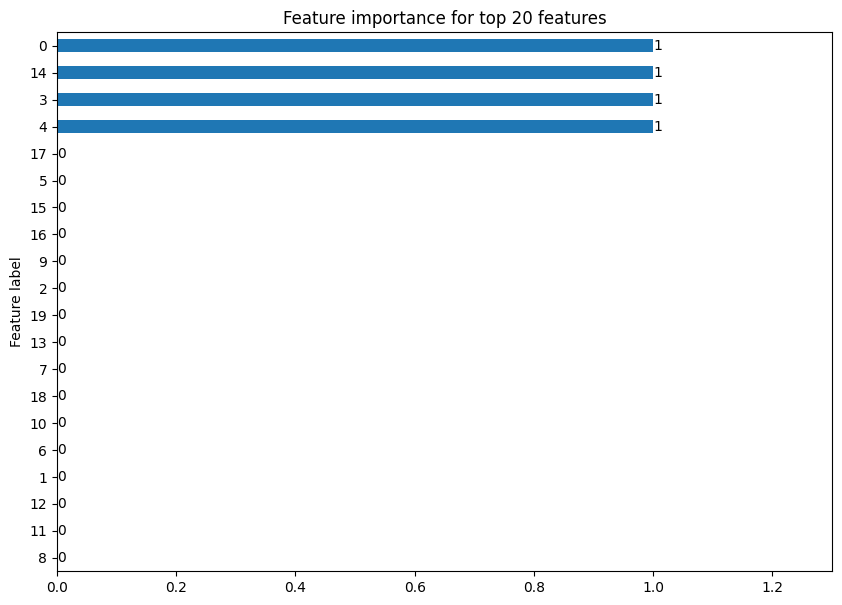

Explanation for graph aalA2_Mod.1.pdb_aligned: tensor([4.0288e-11, 0.0000e+00, 0.0000e+00, 3.9958e-11, 0.0000e+00, 4.0040e-11,
        4.7767e-11, 0.0000e+00, 4.0082e-11, 3.9888e-11, 0.0000e+00, 1.0000e+00,
        3.9946e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 4.0713e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.7246e-11, 6.4056e-02, 0.0000e+00, 2.2454e-01,
        0.0000e+00, 0.0000e+00, 4.2149e-11, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

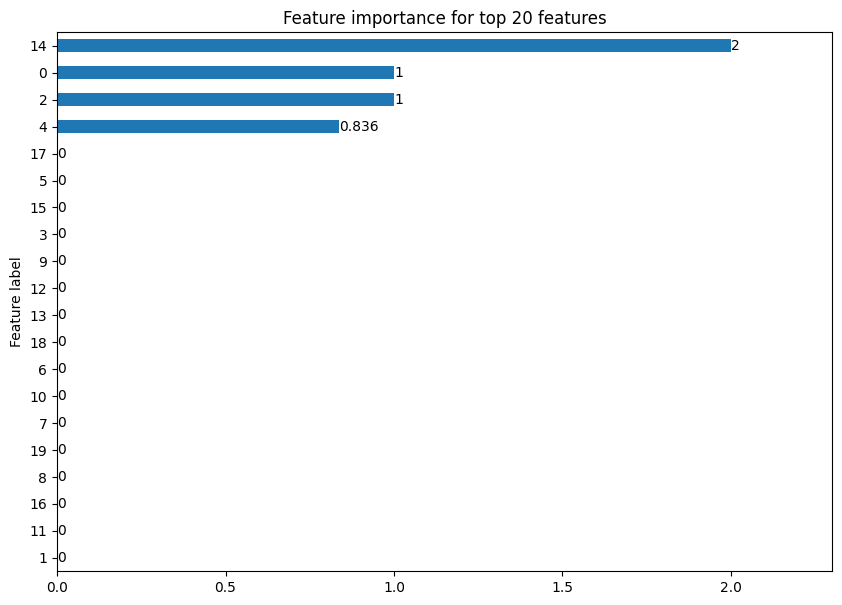

Explanation for graph pteA5_Mod.1.pdb_aligned: tensor([4.5003e-11, 3.8122e-11, 0.0000e+00, 4.4701e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.2922e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 4.4641e-11, 1.0000e+00, 0.0000e+00, 4.8020e-11, 0.0000e+00,
        4.7740e-11, 2.3722e-01, 0.0000e+00, 4.4663e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.4563e-11, 0.0000e+00, 0.0000e+00, 4.4708e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

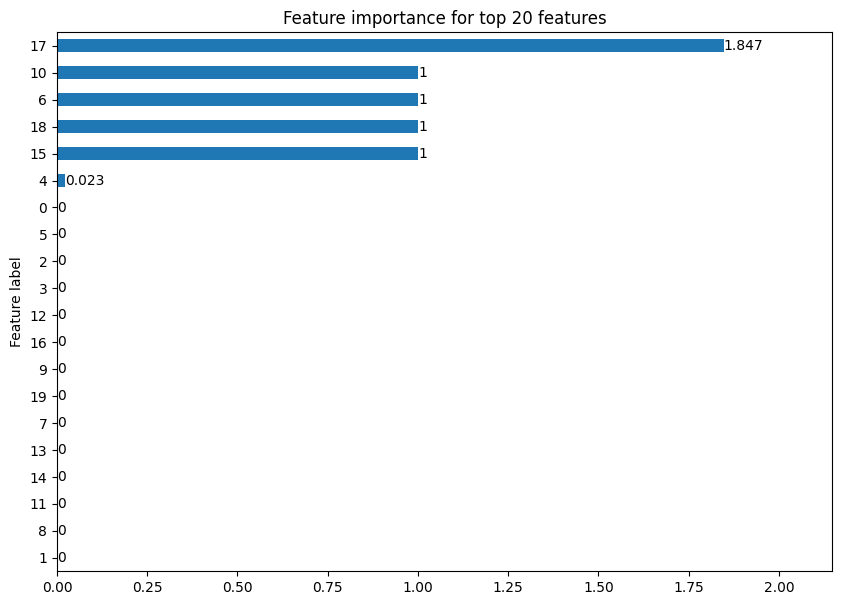

Explanation for graph zinE_Mod.1.pdb_aligned: tensor([3.8551e-11, 0.0000e+00, 0.0000e+00, 3.8285e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

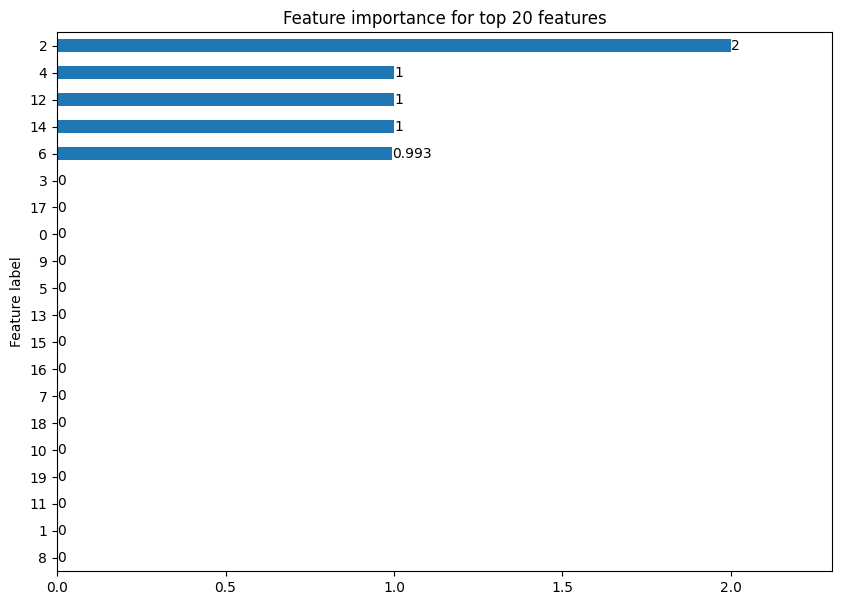

Explanation for graph asmA_Mod.2.pdb_aligned: tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 3.3694e-11, 0.0000e+00, 3.3453e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.3678e-11, 0.0000e+00, 6.9408e-11, 3.3687e-11, 0.0000e+00, 7.0369e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

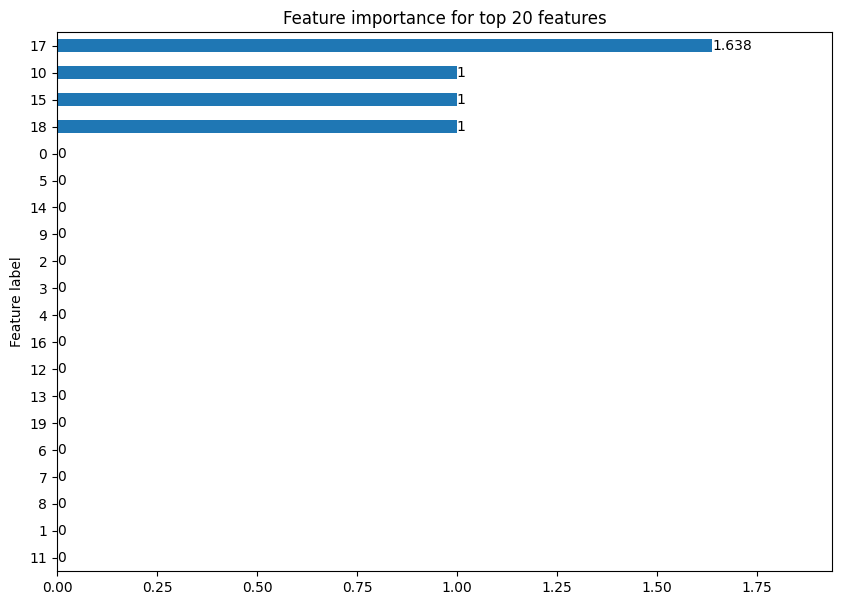

Explanation for graph idnP4_Mod.1.pdb_aligned: tensor([3.8052e-11, 0.0000e+00, 0.0000e+00, 3.7522e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9728e-11, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7759e-11, 6.1704e-11, 0.0000e+00,
        4.7727e-11, 5.4077e-11, 4.5474e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

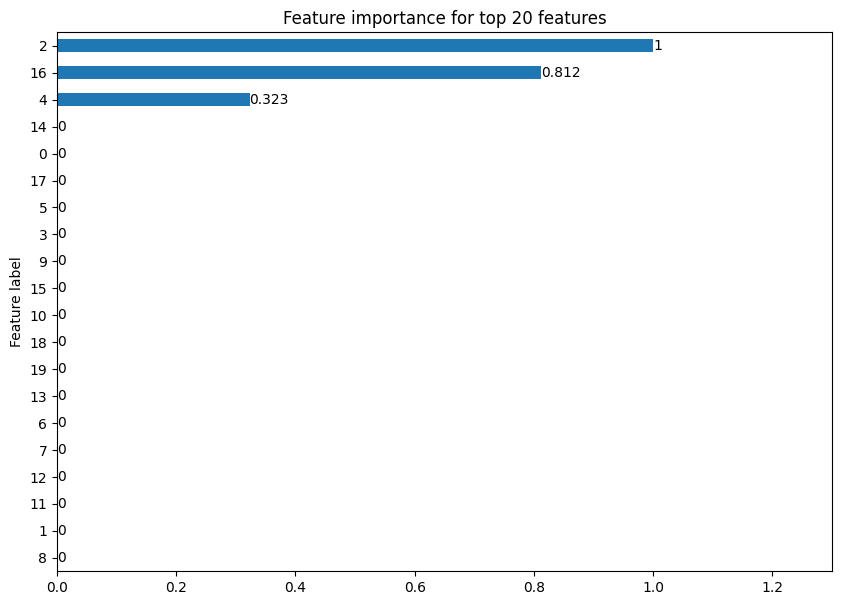

Explanation for graph hgcD_Mod.1.pdb_aligned: tensor([4.0287e-11, 0.0000e+00, 0.0000e+00, 3.9979e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 4.0390e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

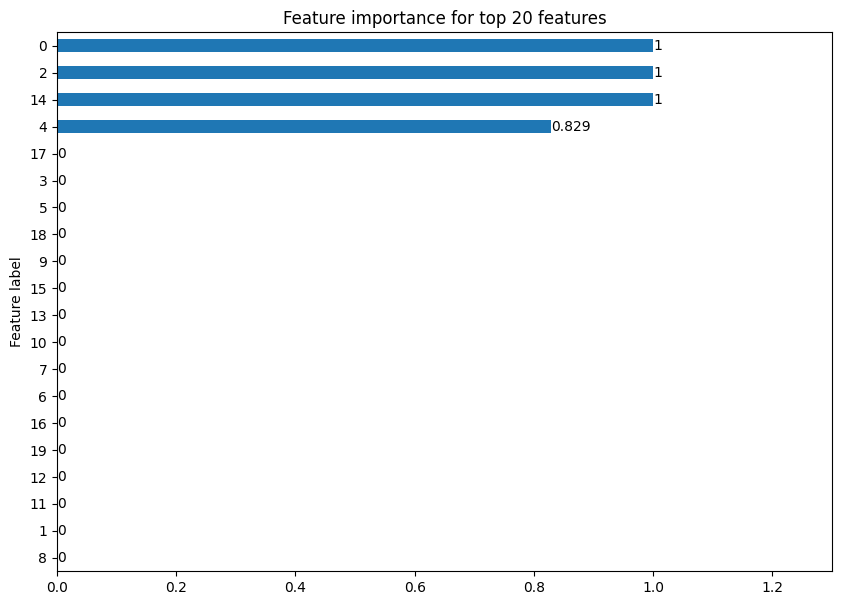

Explanation for graph AceP4_Mod.4.pdb_aligned: tensor([3.9091e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8975e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 9.3526e-11, 7.3814e-11, 0.0000e+00, 3.8600e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

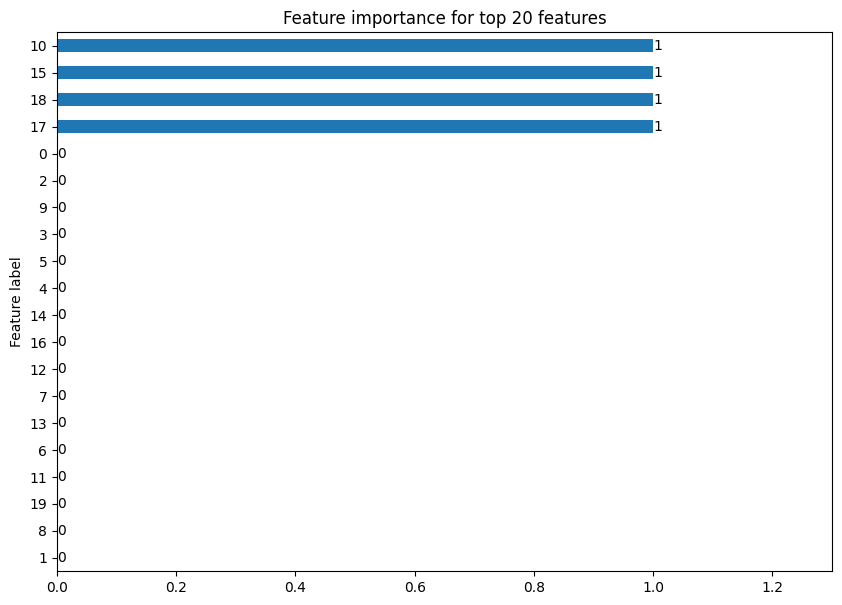

Explanation for graph ttnB_Mod.4.pdb_aligned: tensor([4.1100e-11, 0.0000e+00, 0.0000e+00, 4.0957e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2322e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 4.1215e-11, 2.3608e-01, 0.0000e+00, 0.0000e+00, 4.1285e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3546e-11, 5.6374e-11, 0.0000e+00,
        0.0000e+00, 5.8108e-11, 4.1138e-11, 0.0000e+00, 4.1487e-11, 4.1133e-11,
        4.1624e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

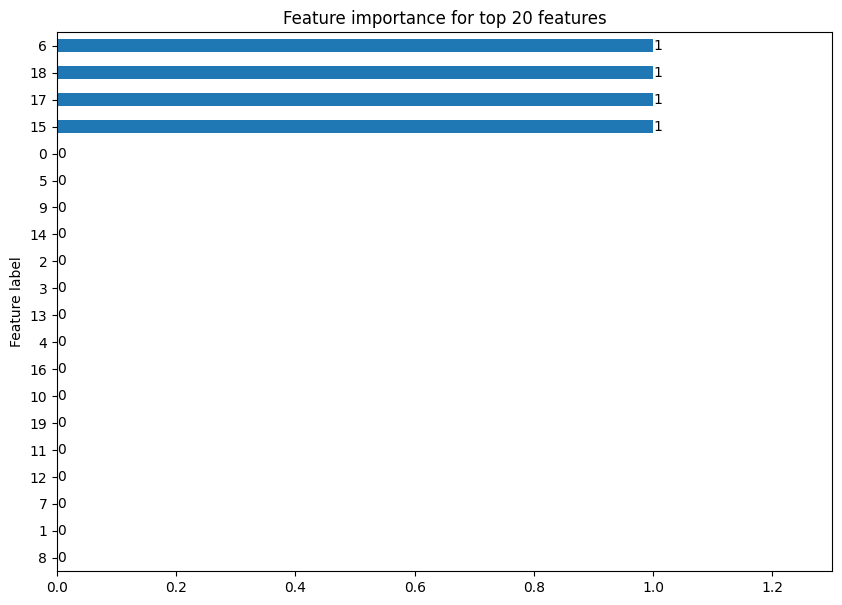

Explanation for graph pimS2_Mod.2.pdb_aligned: tensor([2.4653e-11, 0.0000e+00, 0.0000e+00, 3.4111e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.5003e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        3.3689e-11, 1.0000e+00, 3.3375e-11, 3.3722e-11, 0.0000e+00, 3.3896e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.3420e-11, 3.4693e-11, 0.0000e+00, 0.0000e+00, 0.000

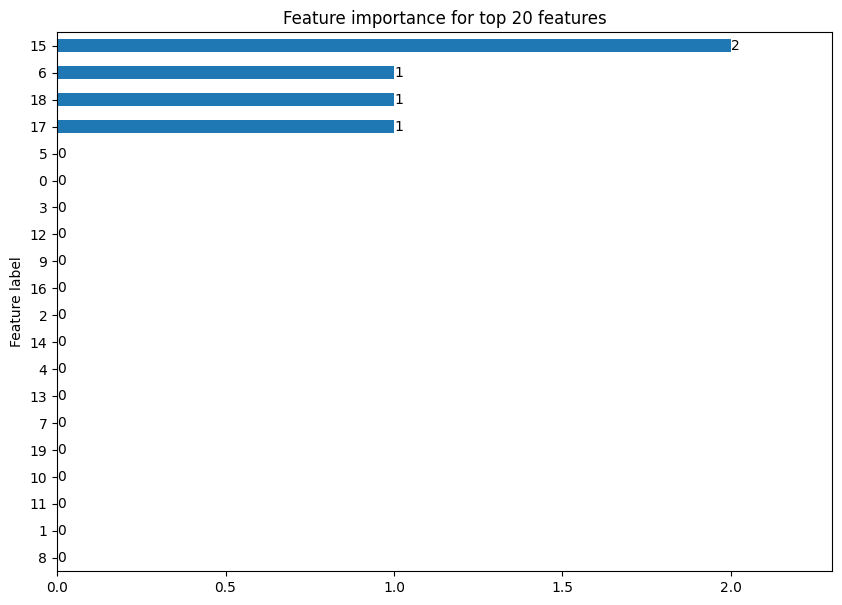

Explanation for graph acuAVII_Mod.1.pdb_aligned: tensor([4.4377e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.4148e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 8.3902e-11, 7.1964e-11, 4.3875e-11, 4.4089e-11,
        2.3567e-01, 4.4094e-11, 0.0000e+00, 4.7393e-11, 4.7576e-11, 0.0000e+00,
        4.4112e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8

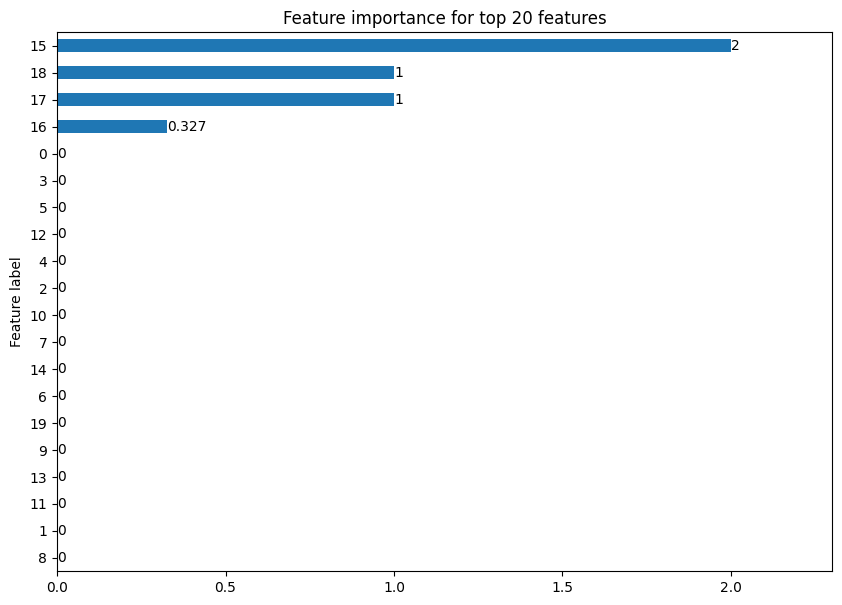

Explanation for graph chmGI_Mod.1.pdb_aligned: tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.9679e-11, 2.9670e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

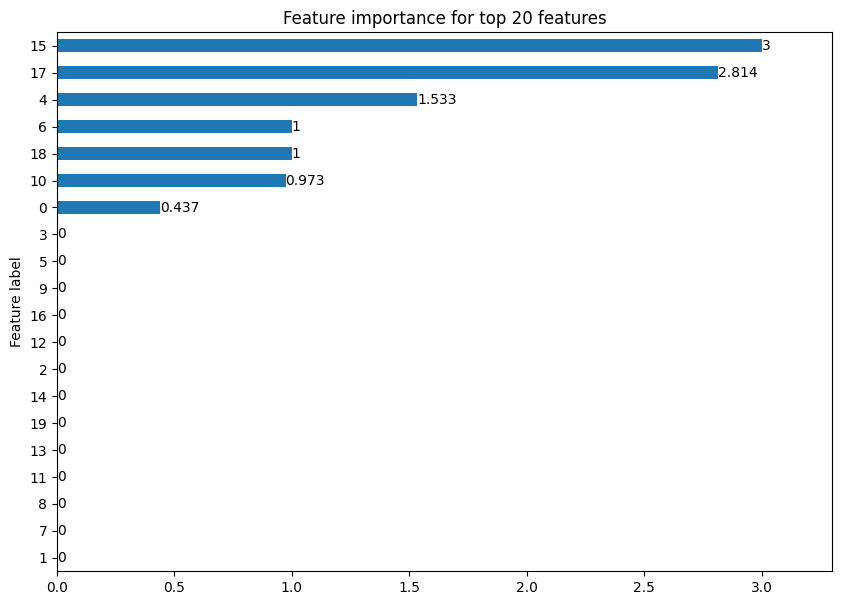

Explanation for graph BafAIII_Mod.2.pdb_aligned: tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8307e-11,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8324e-11, 0.0000e+00,
        3.8353e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0

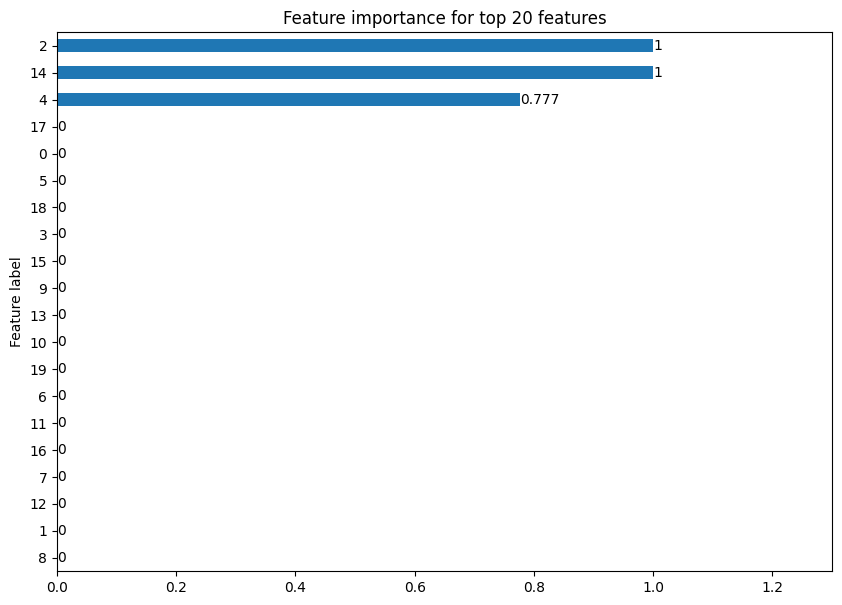

Explanation for graph HerB_Mod.2.pdb_aligned: tensor([4.3269e-11, 0.0000e+00, 0.0000e+00, 4.2603e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 4.1197e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2938e-11,
        0.0000e+00, 4.2934e-11, 0.0000e+00, 0.0000e+00, 4.6326e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

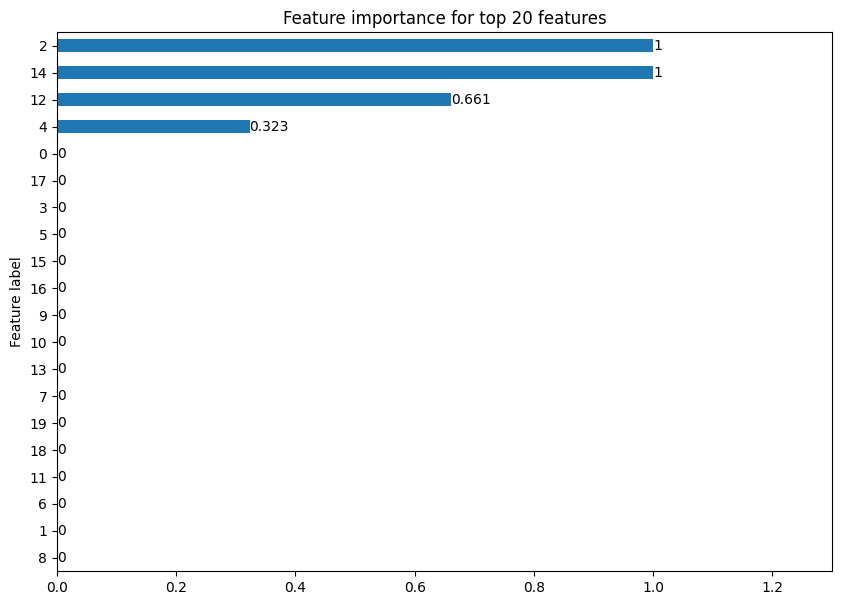

Explanation for graph fosE_Mod.1.pdb_aligned: tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 3.8885e-11, 0.0000e+00,
        3.8620e-11, 0.0000e+00, 4.1693e-11, 0.0000e+00, 3.9133e-11, 2.3588e-01,
        4.1639e-11, 0.0000e+00, 3.8942e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.9012e-11, 0.0000e+00, 4.8797e-11, 3.8973e-11,
        0.0000e+00, 4.8849e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8927e-11,
        0.0000e+00, 0.0000e+00, 3.8876e-11, 3.8908e-11, 0.0000e+00, 3.9181e-11,
        3.8939e-11, 0.0000e+00, 3.9179e-11, 0.0000e+00, 0.0000e+00, 0.0000

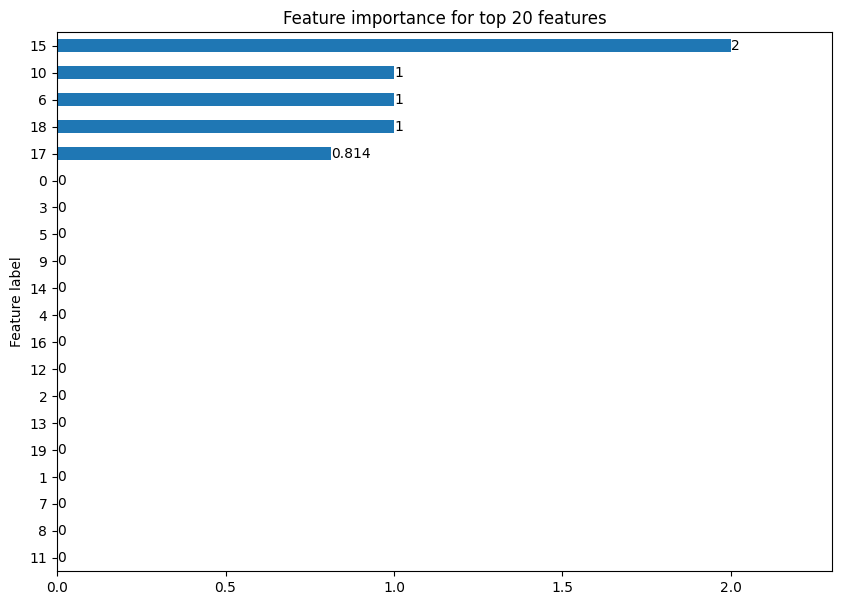

Explanation for graph nysC_Mod.5.pdb_aligned: tensor([7.0675e-01, 0.0000e+00, 0.0000e+00, 4.2865e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.5034e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 4.2863e-11, 0.0000e+00, 4.2538e-11, 0.0000e+00, 4.6206e-11,
        0.0000e+00, 2.3586e-01, 4.6364e-11, 2.3674e-01, 4.6814e-11, 4.2985e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3073e-11,
        0.0000e+00, 7.6378e-11, 4.3003e-11, 0.0000e+00, 7.7438e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2906e-11, 4.2906e-11, 0.0000e+00,
        4.2898e-11, 4.2927e-11, 0.0000e+00, 4.2895e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

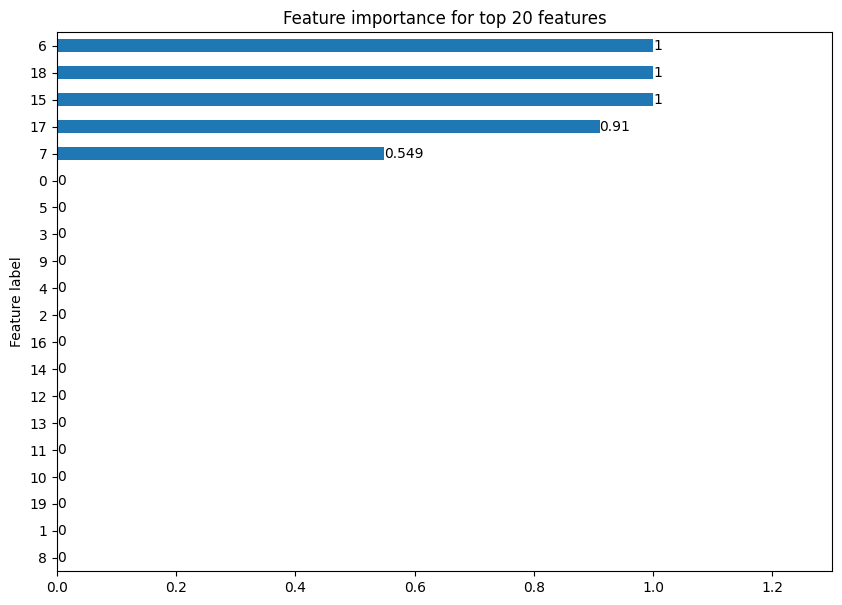

Explanation for graph aalA1_Mod.1.pdb_aligned: tensor([3.8217e-11, 0.0000e+00, 0.0000e+00, 3.2499e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 3.2660e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.2943e-11, 4.8961e-01, 0.0000e+00, 4.1688e-01, 0.0000e+00,
        0.0000e+00, 3.2507e-11, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

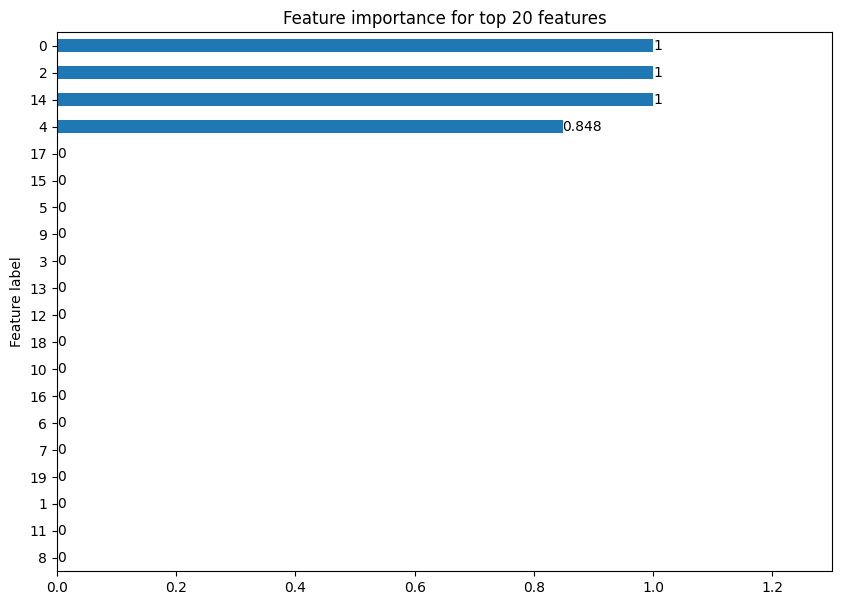

Explanation for graph pikAI_Mod.1.pdb_aligned: tensor([3.7919e-11, 0.0000e+00, 0.0000e+00, 2.5610e-11, 3.7688e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 3.7888e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.7761e-11, 9.9125e-11, 0.0000e+00, 1.0000e+00, 8.8414e-11, 0.0000e+00,
        3.7743e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

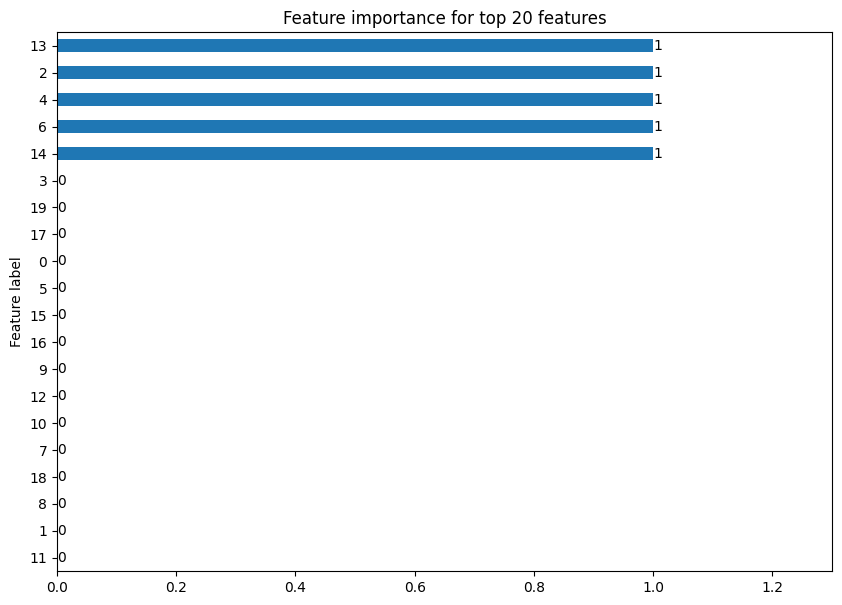

Explanation for graph hgcA_Mod.2.pdb_aligned: tensor([3.5976e-11, 0.0000e+00, 0.0000e+00, 3.5982e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8572e-11, 0.0000e+00, 0.0000e+00,
        3.8598e-11, 0.0000e+00, 2.3590e-01, 0.0000e+00, 3.6000e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 3.6001e-11, 3.2771e-11, 0.0000e+00, 3.6737e-11, 9.2793e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.2968e-11, 3.5925e-11, 0.0000e+00,
        3.5926e-11, 3.5910e-11, 0.0000e+00, 3.5948e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

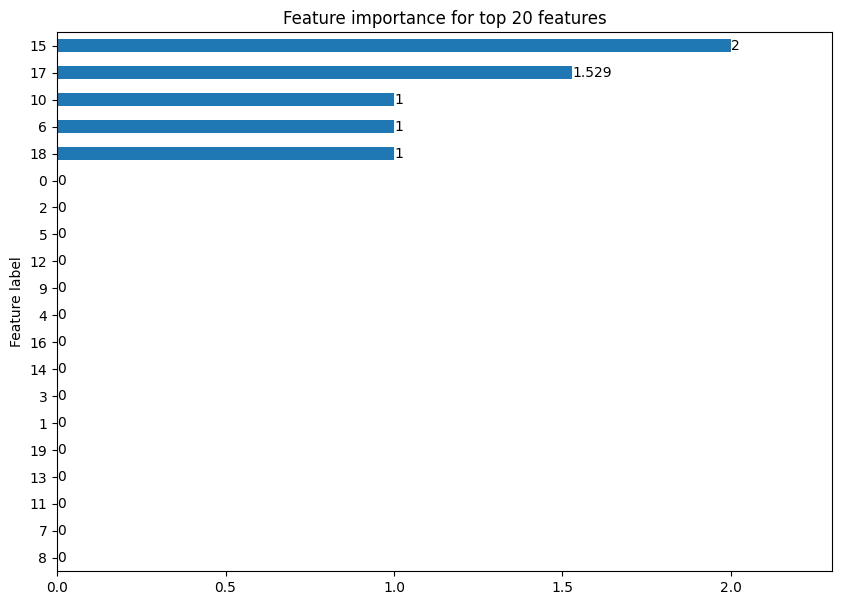

Explanation for graph pikAI_Mod.3.pdb_aligned: tensor([3.6775e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6660e-11, 0.0000e+00,
        0.0000e+00, 3.6588e-11, 0.0000e+00, 0.0000e+00, 3.6596e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.2455e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 7.0318e-11, 5.9957e-11, 3.6330e-11, 3.6595e-11, 0.0000e+00,
        3.6632e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

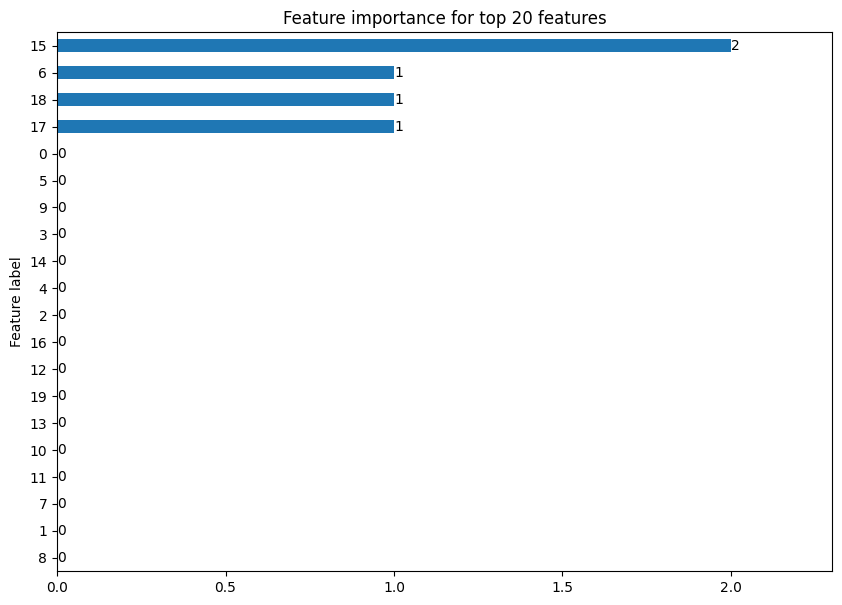

Explanation for graph nemA1-2_Mod.2.pdb_aligned: tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.9459e-11, 6.0989e-11,
        0.0000e+00, 0.0000e+00, 3.9770e-11, 4.0060e-11, 0.0000e+00, 4.0098e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0065e-11, 0.0000e+00,
        4.0035e-11, 4.0064e-11, 4.0113e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0058e-11, 4.0182e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0631e-11, 0.0000e+00, 4.0

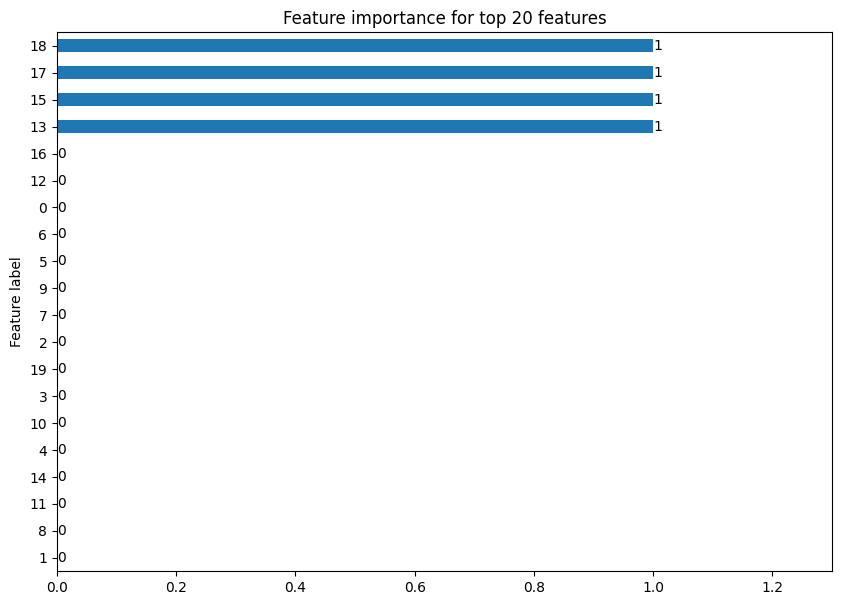

Explanation for graph ttmJ_Mod.6.pdb_aligned: tensor([3.7429e-11, 0.0000e+00, 0.0000e+00, 3.7023e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 3.7453e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

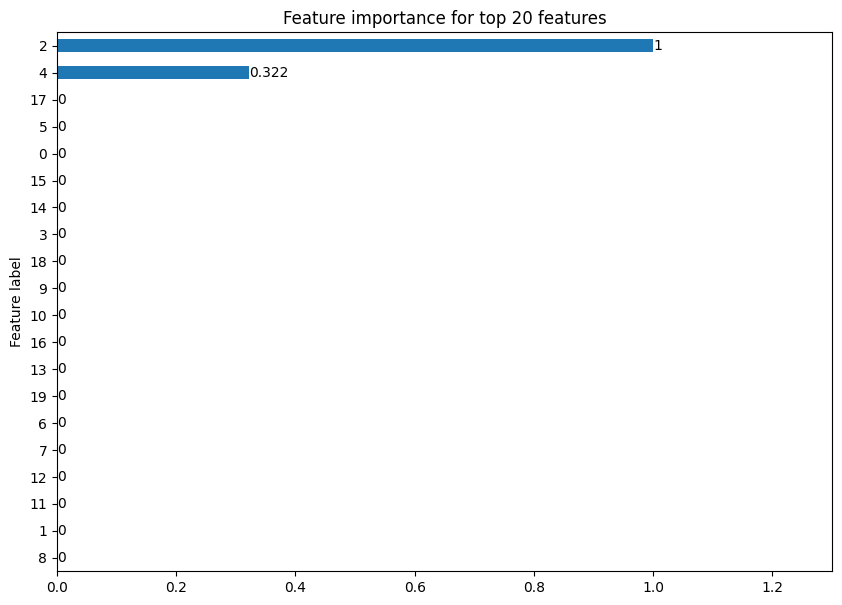

Explanation for graph vstA1_Mod.3.pdb_aligned: tensor([3.9731e-11, 0.0000e+00, 0.0000e+00, 3.9272e-11, 0.0000e+00, 0.0000e+00,
        3.9455e-11, 0.0000e+00, 3.9491e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.9486e-11, 3.9482e-11, 4.1989e-11, 0.0000e+00, 4.1996e-11,
        2.3591e-01, 0.0000e+00, 3.9410e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

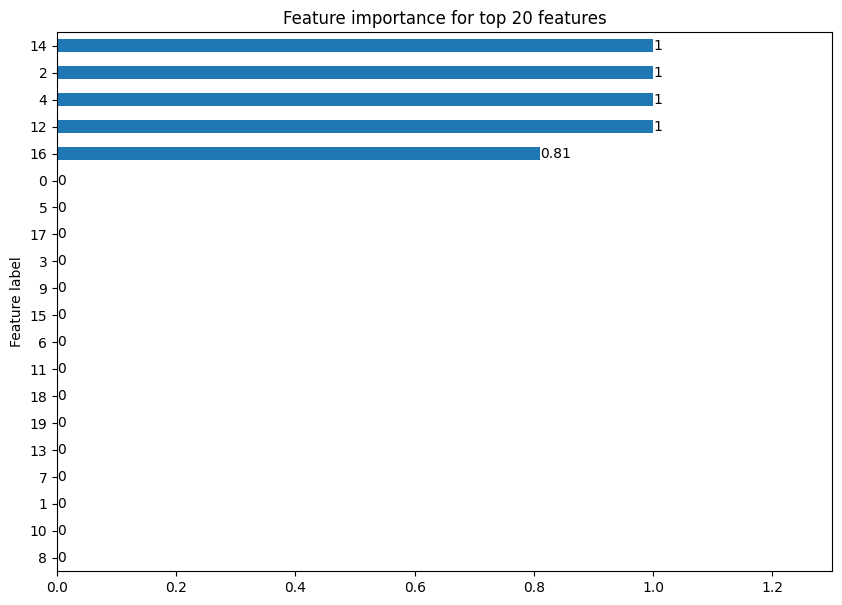

Explanation for graph norC_Mod.1.pdb_aligned: tensor([4.0053e-11, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 4.0060e-11, 0.0000e+00, 4.0063e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

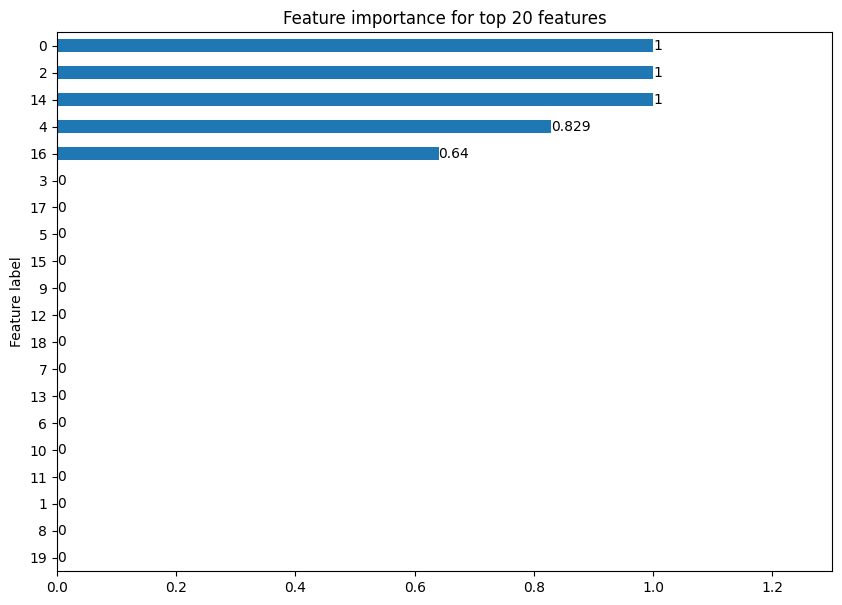

Explanation for graph acuAII_Mod.2.pdb_aligned: tensor([6.7363e-11, 0.0000e+00, 0.0000e+00, 2.6677e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 2.6819e-11, 4.2324e-01, 0.0000e+00,
        5.0344e-01, 2.7191e-11, 0.0000e+00, 2.6933e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

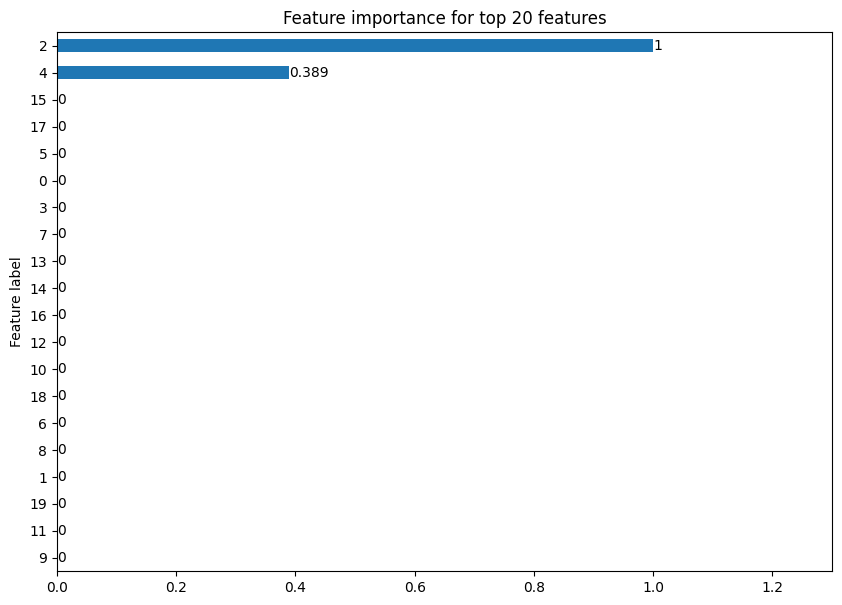

Explanation for graph slnA3_Mod.2.pdb_aligned: tensor([3.6242e-11, 0.0000e+00, 0.0000e+00, 3.6162e-11, 0.0000e+00, 0.0000e+00,
        3.6777e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 3.5947e-11, 3.5685e-11, 0.0000e+00, 3.8677e-11,
        0.0000e+00, 3.8753e-11, 0.0000e+00, 2.3639e-01, 0.0000e+00, 3.6029e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.1416e-11, 0.0000e+00, 1.8993e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

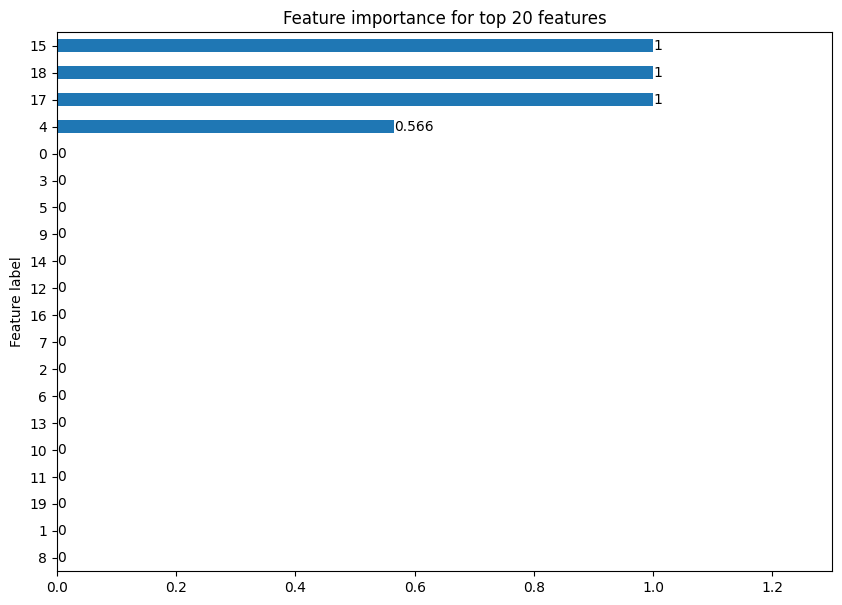

Explanation for graph selI_Mod.5.pdb_aligned: tensor([3.6208e-11, 3.6024e-11, 0.0000e+00, 3.6021e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 3.6319e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

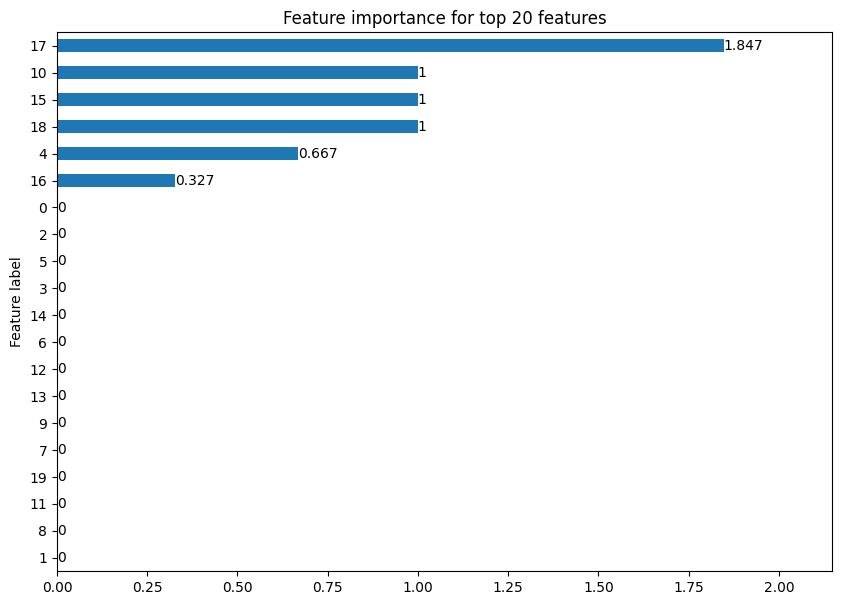

Explanation for graph lasAIV_Mod.1.pdb_aligned: tensor([3.7449e-11, 0.0000e+00, 0.0000e+00, 3.6749e-11, 0.0000e+00, 3.7169e-11,
        0.0000e+00, 3.7156e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.7168e-11, 0.0000e+00, 3.7174e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

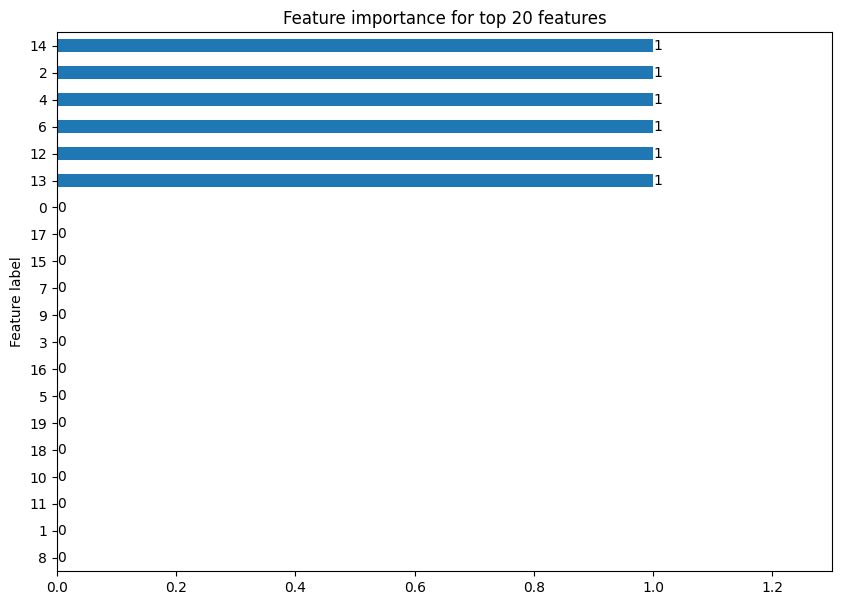

Explanation for graph fscC_Mod.2.pdb_aligned: tensor([4.0894e-11, 0.0000e+00, 3.0232e-11, 4.0730e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.5025e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.1359e-11, 5.6083e-11, 1.0000e+00, 0.0000e+00, 4.3575e-11, 0.0000e+00,
        0.0000e+00, 4.3540e-11, 2.3549e-01, 0.0000e+00, 4.0633e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.0675e-11, 0.0000e+00, 4.0684e-11, 4.0642e-11, 0.0000e+00,
        4.0638e-11, 4.0644e-11, 0.0000e+00, 4.0731e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

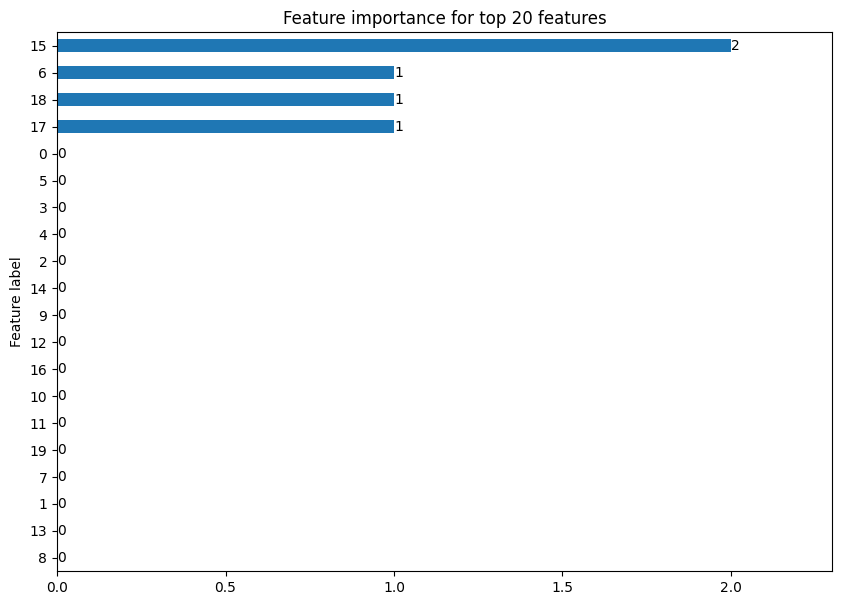

Explanation for graph lkmAI_Mod.2.pdb_aligned: tensor([4.1807e-11, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        4.1791e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 8.3252e-11, 0.0000e+00, 8.3683e-11,
        0.0000e+00, 4.1704e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

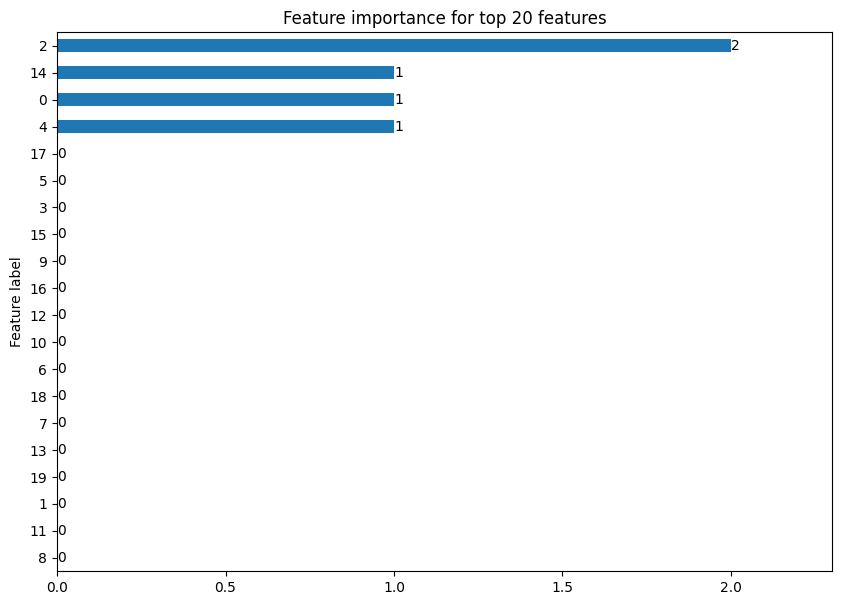

Explanation for graph cle1_Mod.2.pdb_aligned: tensor([3.9753e-11, 1.0000e+00, 0.0000e+00, 3.9635e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.1962e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.9399e-11, 6.0901e-11, 3.9047e-11, 0.0000e+00, 4.2627e-11, 0.0000e+00,
        4.2552e-11, 2.3584e-01, 0.0000e+00, 3.9486e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

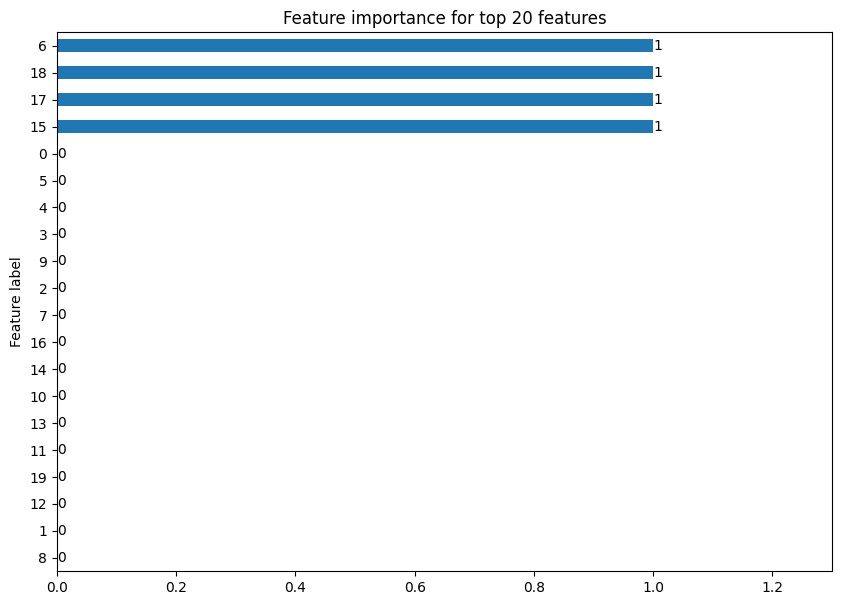

Explanation for graph idnP3_Mod.2.pdb_aligned: tensor([5.3909e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2956e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 5.3872e-11, 5.3877e-11, 1.0000e+00,
        4.2027e-11, 5.8131e-11, 5.3892e-11, 1.4523e-01, 1.4583e-01, 5.7885e-11,
        6.3157e-11, 5.3929e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.3867e-11, 5.4552e-11, 0.0000e+00, 5.4506e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

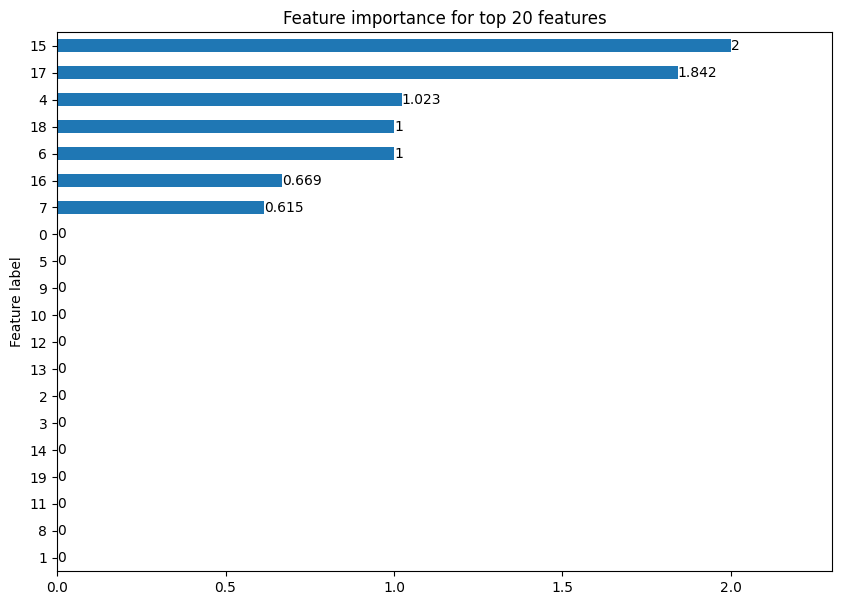

Explanation for graph nidA2_Mod.1.pdb_aligned: tensor([4.6002e-11, 0.0000e+00, 0.0000e+00, 4.5803e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.5889e-11, 0.0000e+00, 4.5826e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.2396e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5787e-11, 1.0005e-10,
        4.6030e-11, 0.0000e+00, 1.0111e-10, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.5923e-11, 0.0000e+00, 4.5790e-11, 4.5801e-11, 0.0000e+00, 4.6140e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

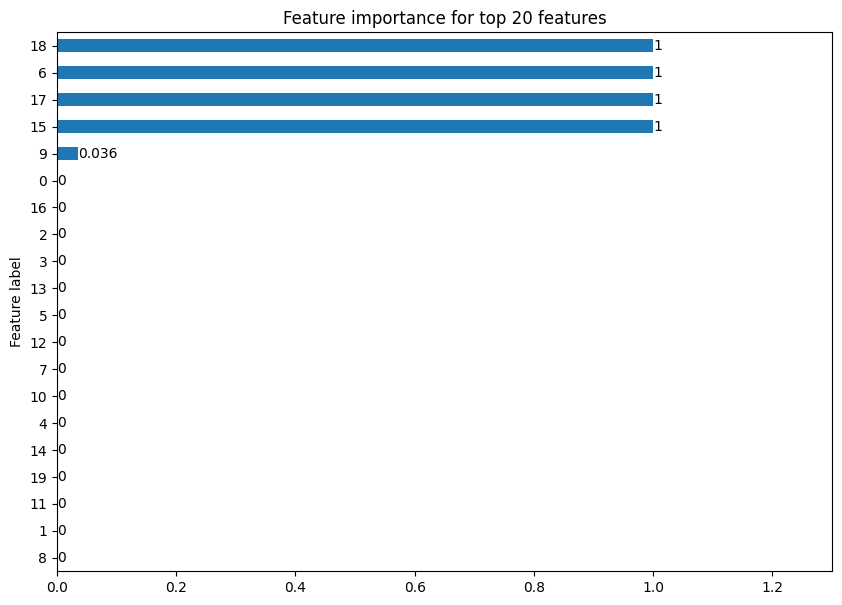

Explanation for graph lkmAIII_Mod.1.pdb_aligned: tensor([4.3759e-11, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 4.5907e-11, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3525e-11, 4.3503e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0

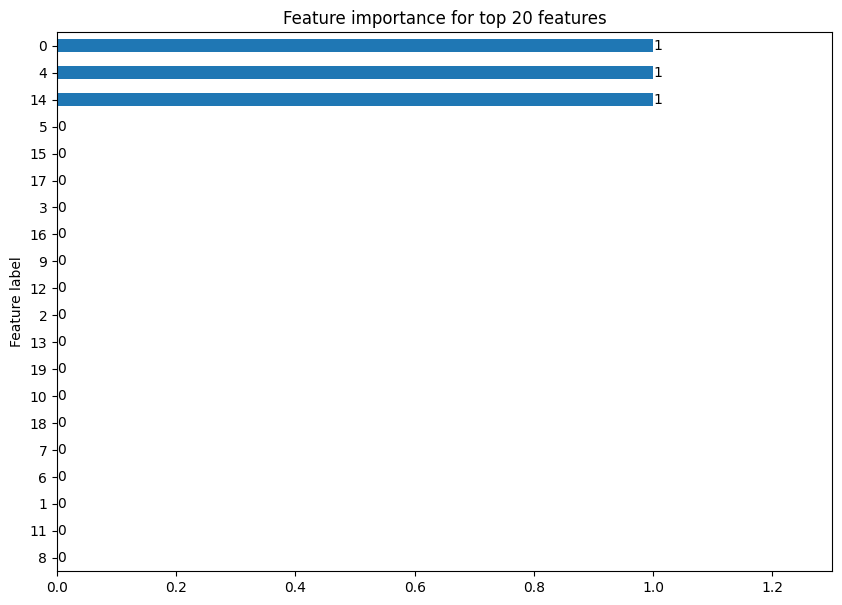

Explanation for graph phn2_Mod.3.pdb_aligned: tensor([4.0070e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9983e-11, 0.0000e+00,
        4.0063e-11, 0.0000e+00, 4.0005e-11, 0.0000e+00, 4.2432e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 3.9929e-11, 1.0000e+00,
        0.0000e+00, 4.2958e-11, 0.0000e+00, 0.0000e+00, 4.2911e-11, 2.3599e-01,
        0.0000e+00, 4.0066e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7281e-11, 0.0000e+00, 2.6147e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

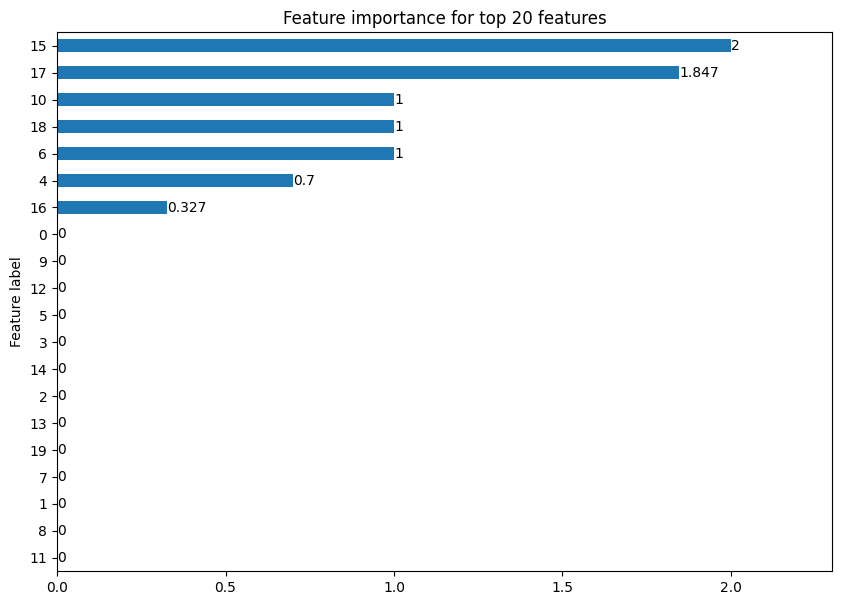

Explanation for graph mlsA2_Mod.1.pdb_aligned: tensor([3.5556e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.4862e-11, 3.4941e-11, 3.7346e-11, 0.0000e+00, 0.0000e+00, 2.3589e-01,
        3.7460e-11, 0.0000e+00, 3.4878e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

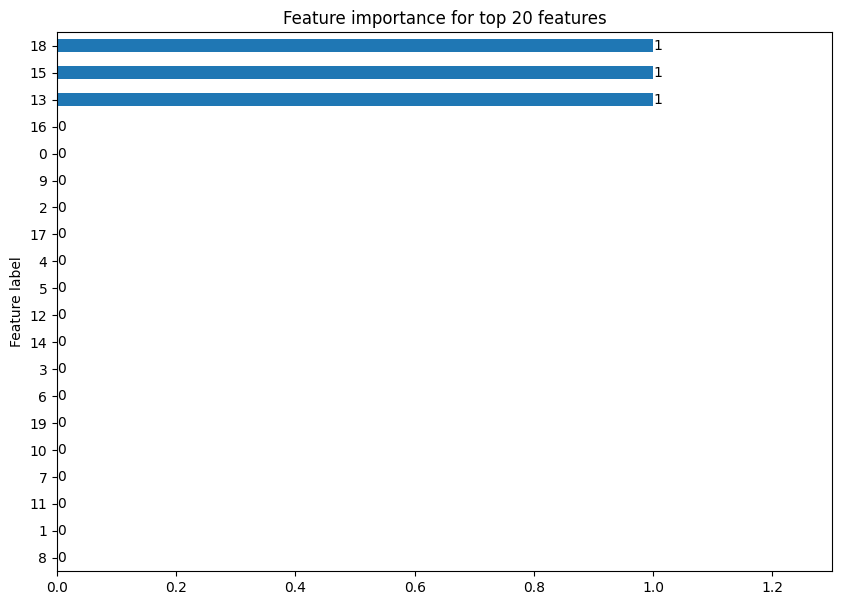

Explanation for graph zinB_Mod.2.pdb_aligned: tensor([4.1547e-11, 0.0000e+00, 0.0000e+00, 4.1021e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 4.1241e-11, 0.0000e+00, 4.0722e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.8389e-02, 0.0000e+00,
        0.0000e+00, 4.6584e-11, 2.2422e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

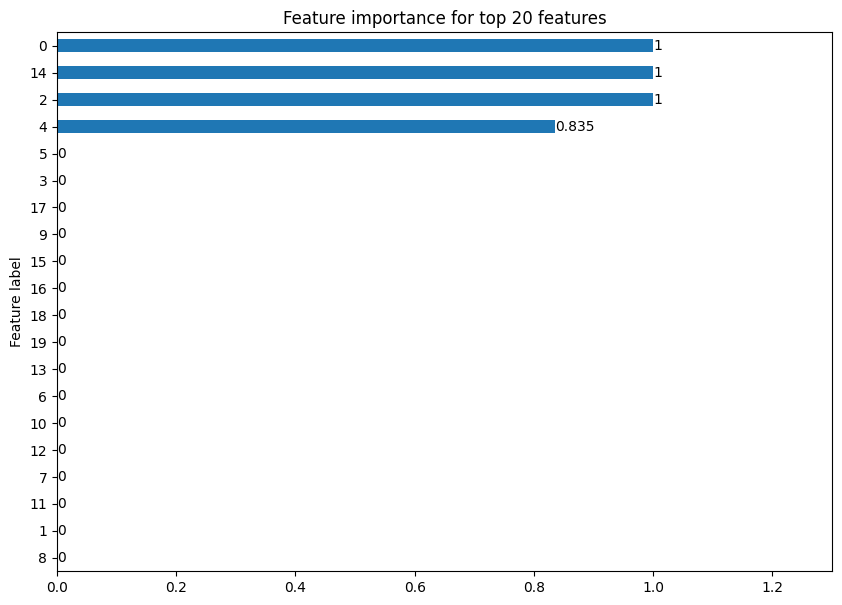

Explanation for graph ladSIV_Mod.1.pdb_aligned: tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.2946e-11, 0.0000e+00, 4.2946e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0584e-10, 0.0000e+00, 0.0000e+00,
        2.0310e-10, 0.0000e+00, 4.3080e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.2865e-11, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2957e-11, 0.0000e+00, 0.0000e+00,
        4.3001e-11, 4.2931e-11, 0.0000e+00, 4.2806e-11, 4.2936e-11, 0.0000e+00,
        4.2782e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

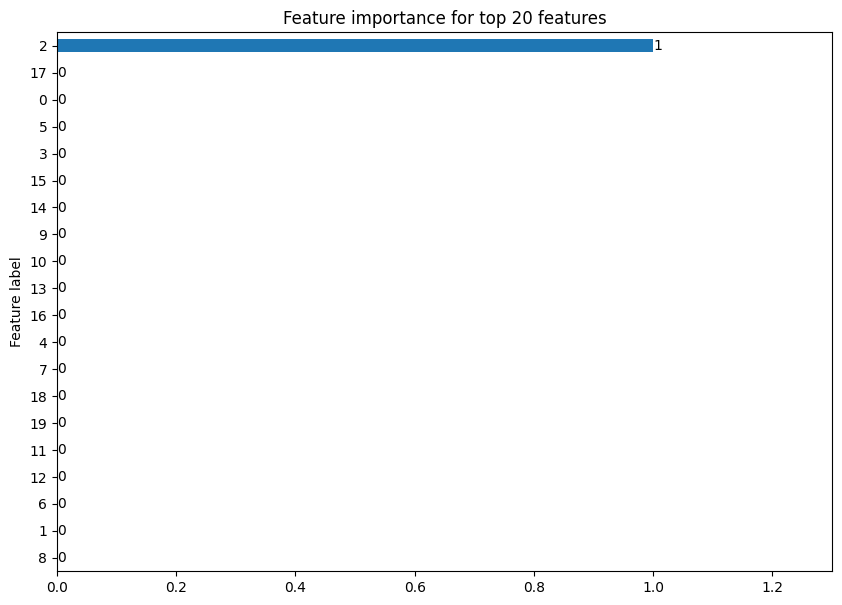

Explanation for graph pimS2_Mod.3.pdb_aligned: tensor([4.0783e-11, 0.0000e+00, 0.0000e+00, 4.0600e-11, 0.0000e+00, 0.0000e+00,
        4.0635e-11, 0.0000e+00, 4.0645e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        4.2535e-11, 1.0000e+00, 4.0837e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.4370e-10, 0.0000e+00, 5.2838e-10,
        0.0000e+00, 4.0678e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0648e-11, 0.0000e+00, 4.0594e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

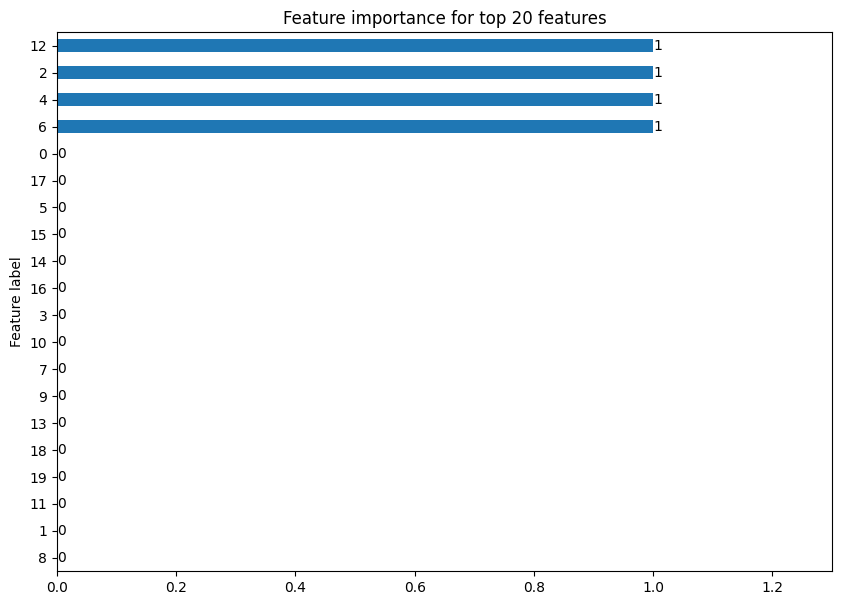

Explanation for graph gerSI_Mod.2.pdb_aligned: tensor([3.9639e-11, 0.0000e+00, 3.9450e-11, 3.9391e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 3.9422e-11, 3.9457e-11, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

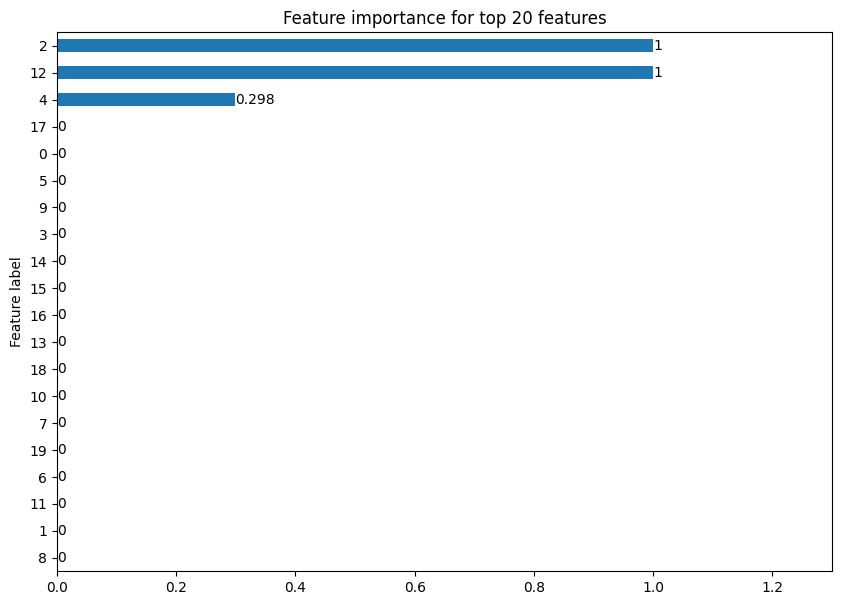

Explanation for graph SCO6275_Mod.2.pdb_aligned: tensor([3.9722e-11, 2.9655e-11, 0.0000e+00, 3.9459e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.1911e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.7234e-11,
        5.9225e-11, 0.0000e+00, 1.0000e+00, 0.0000e+00, 4.2993e-11, 0.0000e+00,
        0.0000e+00, 4.2460e-11, 2.3592e-01, 0.0000e+00, 3.9483e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.9300e-11, 0.0000e+00, 0.0000e+00, 0.0

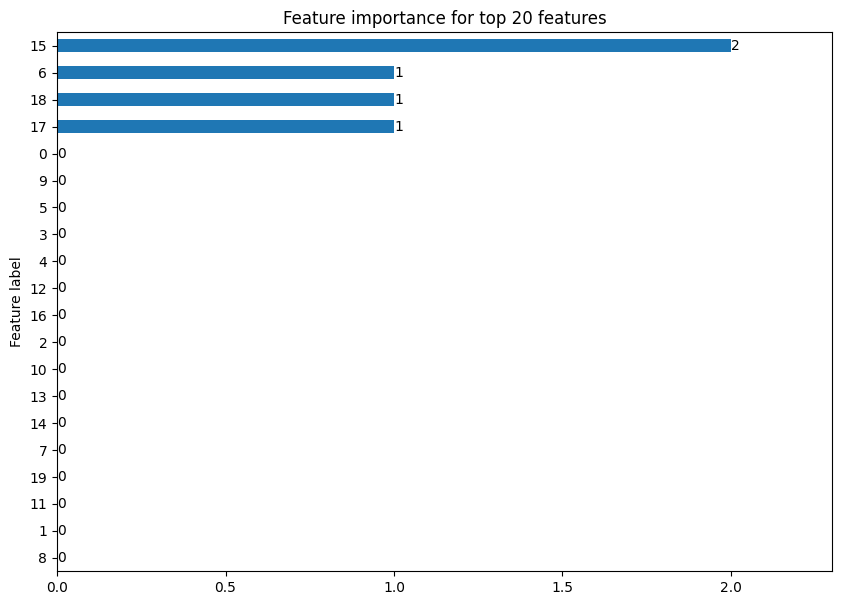

Explanation for graph TamAI_Mod.2.pdb_aligned: tensor([3.0985e-11, 0.0000e+00, 0.0000e+00, 3.0707e-11, 0.0000e+00, 3.0821e-11,
        0.0000e+00, 3.0826e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 3.0742e-11, 0.0000e+00,
        1.0000e+00, 3.0833e-11, 3.3123e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0861e-01, 0.0000e+00, 3.0874e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

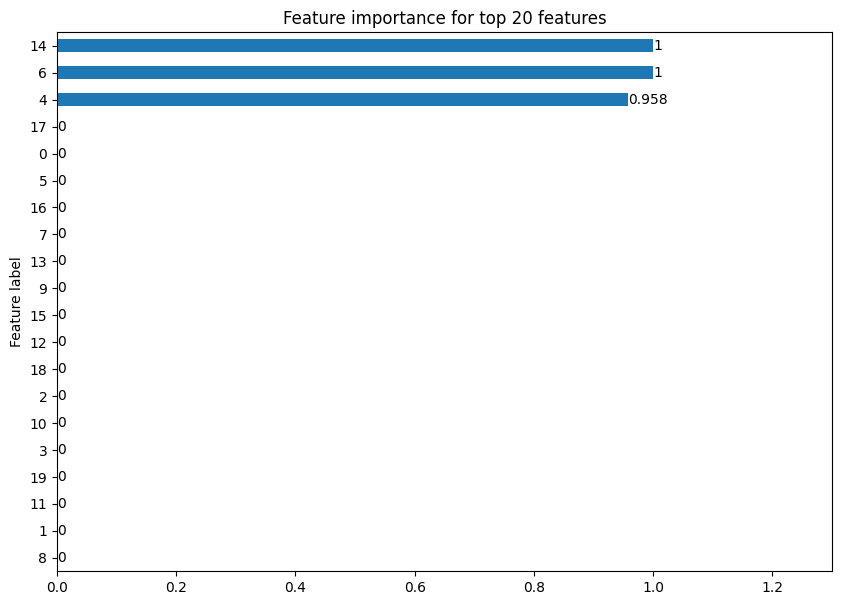

Explanation for graph cle1_Mod.5.pdb_aligned: tensor([4.3229e-11, 4.2806e-11, 0.0000e+00, 4.3004e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 4.2895e-11, 4.2827e-11, 0.0000e+00, 4.5985e-11,
        0.0000e+00, 4.5906e-11, 2.3715e-01, 0.0000e+00, 4.2941e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

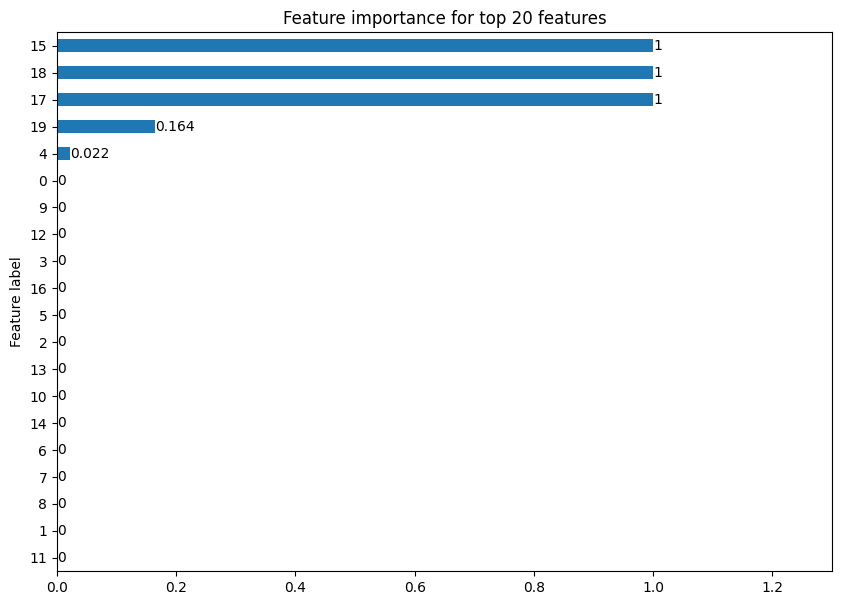

Explanation for graph selK_Mod.1.pdb_aligned: tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.2932e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.3594e-11, 3.5060e-11, 4.5893e-11, 0.0000e+00, 2.3582e-01, 4.3519e-11,
        4.7338e-11, 4.6556e-11, 4.6532e-11, 7.5610e-11, 4.3492e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.2706e-11, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

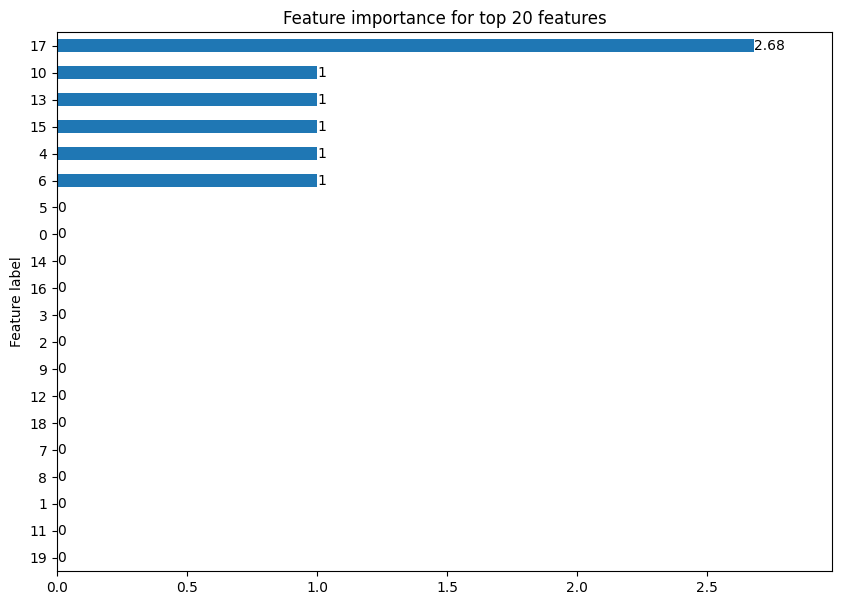

Explanation for graph lobA1_Mod.1.pdb_aligned: tensor([3.6315e-11, 0.0000e+00, 0.0000e+00, 3.5849e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7529e-11,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 7.3987e-11, 0.0000e+00, 0.0000e+00, 7.0478e-11,
        4.9410e-11, 0.0000e+00, 3.5980e-11, 4.6320e-11, 0.0000e+00, 3.5997e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

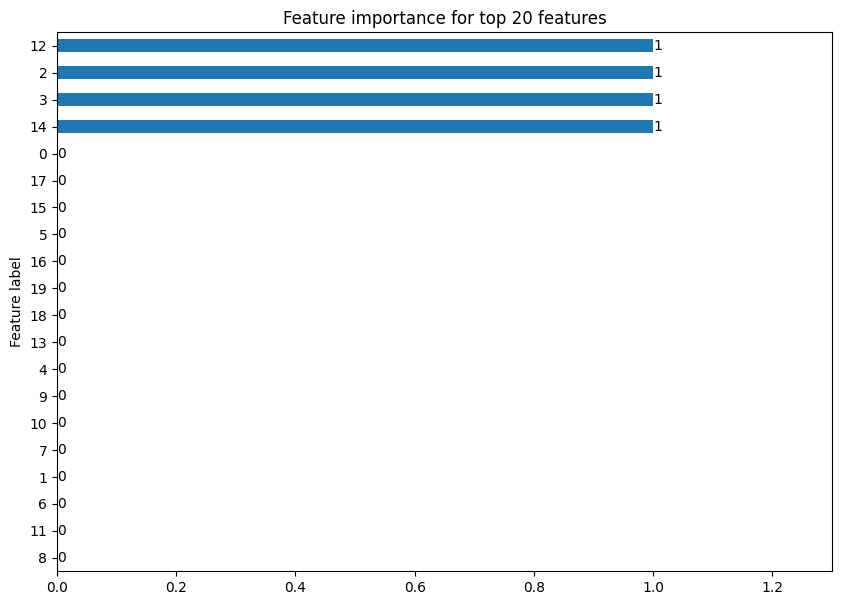

Explanation for graph gfsA_Mod.4.pdb_aligned: tensor([3.3523e-11, 0.0000e+00, 0.0000e+00, 2.4269e-01, 0.0000e+00, 4.3448e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 4.2916e-11, 1.0000e+00, 0.0000e+00, 4.6155e-11,
        0.0000e+00, 0.0000e+00, 4.5905e-11, 2.3593e-01, 0.0000e+00, 4.2947e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3244e-11,
        0.0000e+00, 1.1029e-10, 4.2939e-11, 0.0000e+00, 1.1211e-10, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

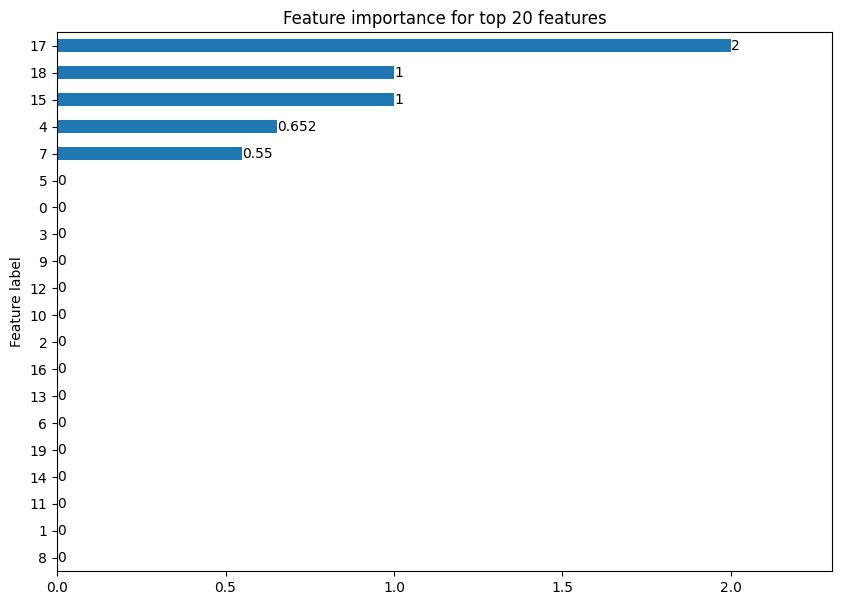

Explanation for graph ladSVIII_Mod.2.pdb_aligned: tensor([3.5996e-11, 0.0000e+00, 3.5948e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 4.6354e-11, 0.0000e+00, 0.0000e+00,
        4.6340e-11, 0.0000e+00, 0.0000e+00, 3.6100e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.

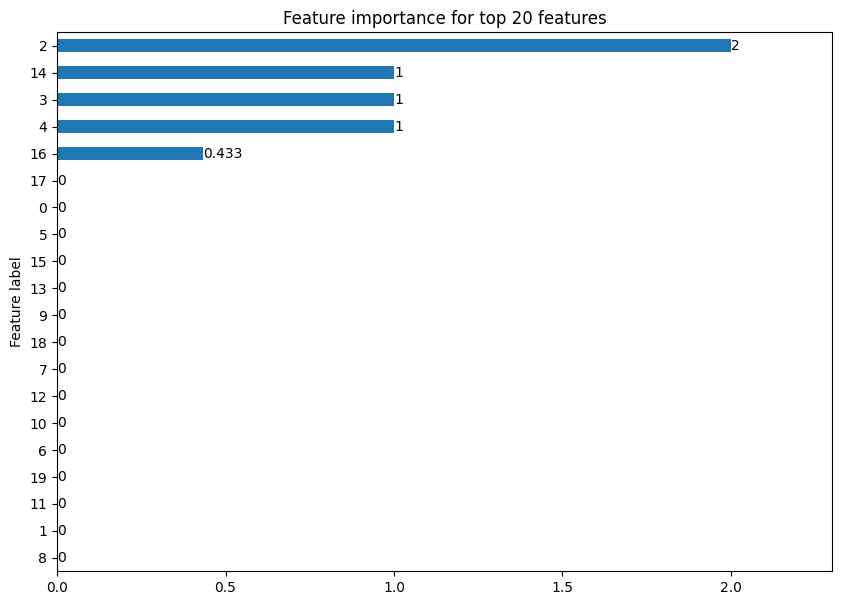

Explanation for graph tiaA4_Mod.2.pdb_aligned: tensor([3.4318e-11, 0.0000e+00, 0.0000e+00, 3.7054e-11, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9339e-01,
        0.0000e+00, 3.5019e-11, 0.0000e+00, 3.4292e-11, 3.4285e-11, 0.0000e+00,
        3.4274e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.4009e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.5329e-11,
        3.4223e-11, 3.4278e-11, 0.0000e+00, 3.4272e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

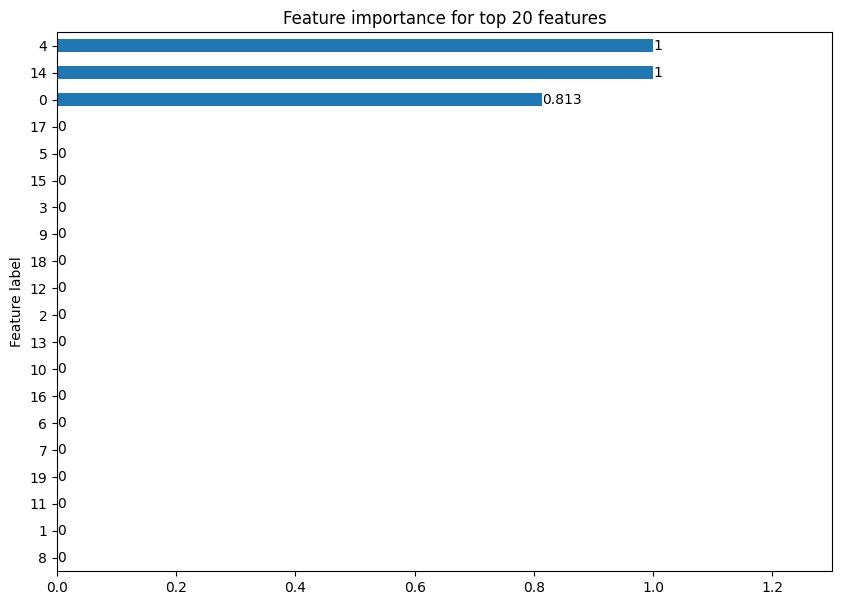

Explanation for graph hitP2_Mod.2.pdb_aligned: tensor([3.9649e-11, 0.0000e+00, 0.0000e+00, 3.9776e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.5045e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.4570e-11,
        5.0956e-11, 3.9244e-11, 3.9537e-11, 4.3192e-11, 0.0000e+00, 0.0000e+00,
        2.3694e-01, 4.2913e-11, 2.3721e-01, 3.9496e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9439e-11,
        0.0000e+00, 3.9405e-11, 0.0000e+00, 3.9877e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

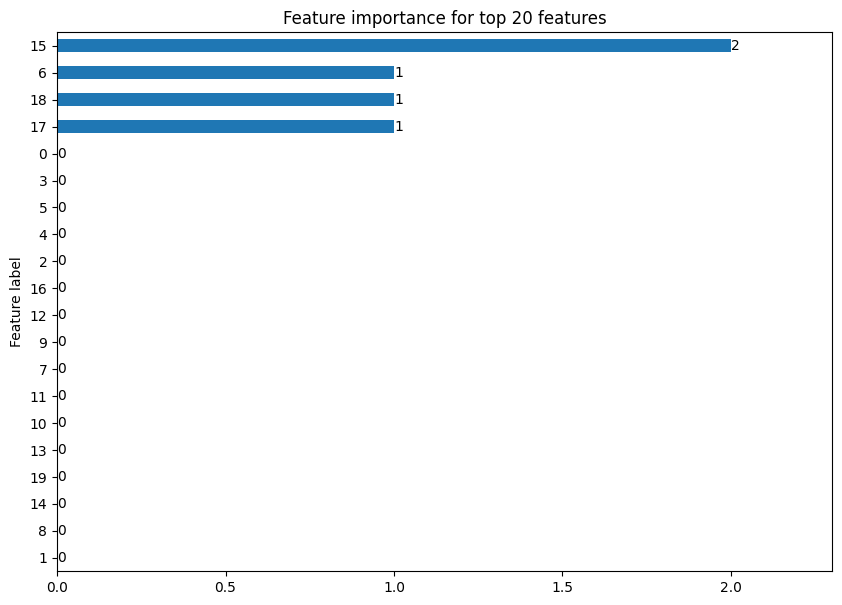

Explanation for graph scnS2_Mod.6.pdb_aligned: tensor([4.0526e-11, 0.0000e+00, 0.0000e+00, 4.0589e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.2934e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        4.0611e-11, 1.0000e+00, 0.0000e+00, 4.3505e-11, 0.0000e+00, 0.0000e+00,
        4.3455e-11, 2.3575e-01, 0.0000e+00, 4.0609e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0796e-11, 0.0000e+00, 6.1224e-11,
        4.0708e-11, 0.0000e+00, 6.1962e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

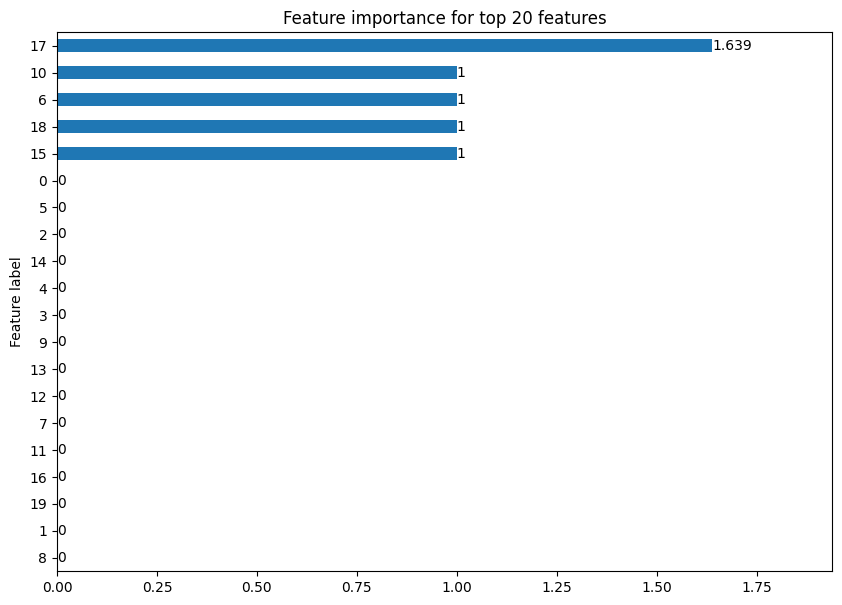

Explanation for graph AceP3_Mod.4.pdb_aligned: tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.1879e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        3.2529e-11, 0.0000e+00, 3.2309e-11, 3.2792e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2547e-11, 3.2723e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.2561e-11, 3.2585e-11, 5.4777e-11, 5.4801e-11, 0.000

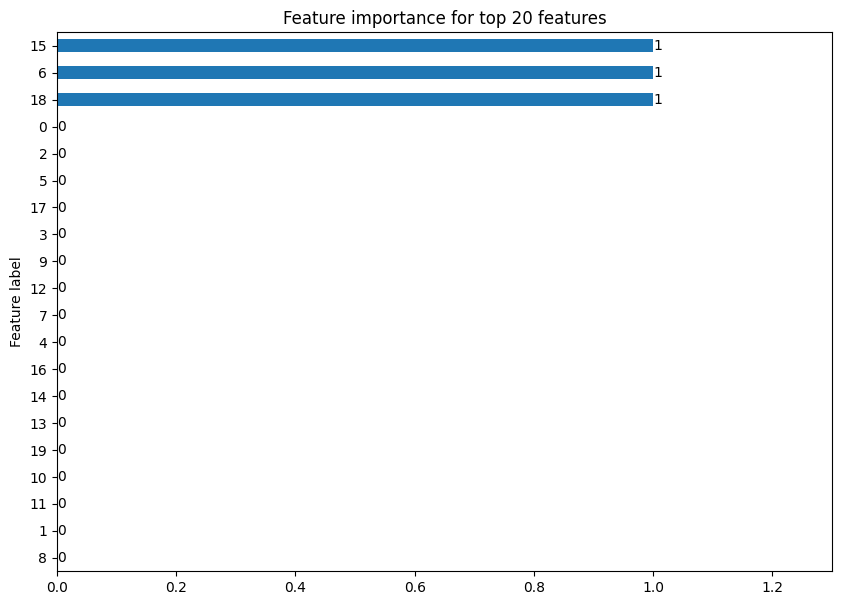

Explanation for graph tiaA2_Mod.2.pdb_aligned: tensor([3.3728e-11, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.2123e-01, 3.4857e-11, 0.0000e+00, 3.3700e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 3.3608e-11,
        3.3665e-11, 3.5342e-11, 0.0000e+00, 4.5503e-01, 3.2211e-01, 0.0000e+00,
        3.4694e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.3699e-11, 0.0000e+00, 3.3679e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

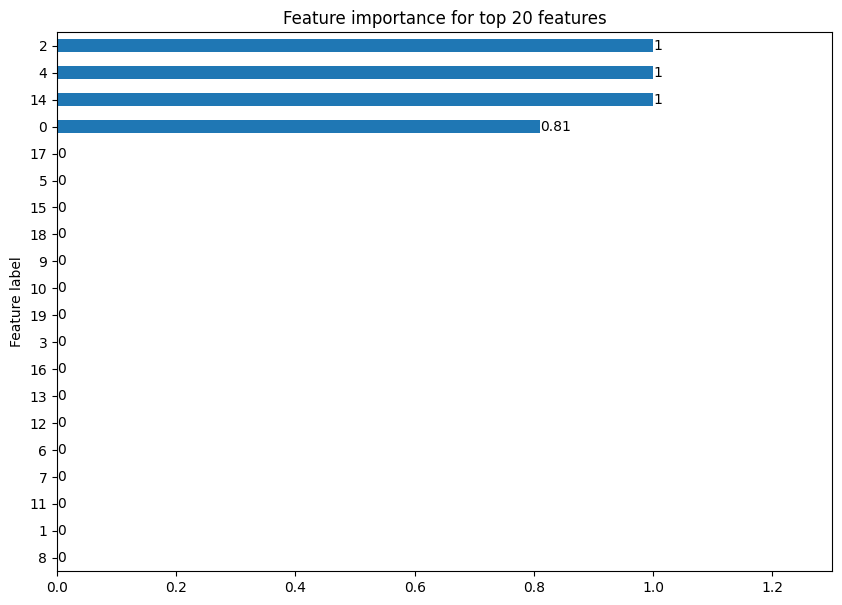

Explanation for graph fscD_Mod.5.pdb_aligned: tensor([3.8989e-11, 0.0000e+00, 0.0000e+00, 3.8890e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.3011e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.9504e-11, 7.1912e-11, 3.8716e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9041e-11, 0.0000e+00,
        3.9390e-11, 3.2900e-11, 0.0000e+00, 3.9735e-11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

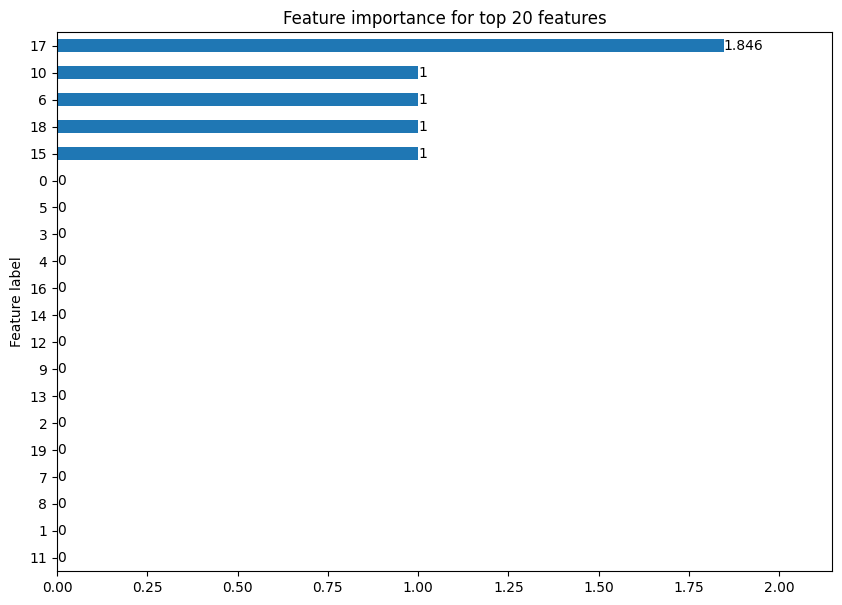

Explanation for graph AceP5_Mod.1.pdb_aligned: tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.8596e-11, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        4.8351e-11, 4.9188e-11, 5.2533e-11, 0.0000e+00, 2.3601e-01, 5.2881e-11,
        1.3684e-10, 4.8695e-11, 1.3681e-10, 0.0000e+00, 4.8888e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8784e-11, 0.0000e+00, 0.0000e+00,
        4.8972e-11, 0.0000e+00, 0.0000e+00, 4.8548e-11, 0.0000e+00, 4.8721e-11,
        0.0000e+00, 4.8736e-11, 4.8634e-11, 0.0000e+00, 0.0000e+00, 4.8564e-11,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

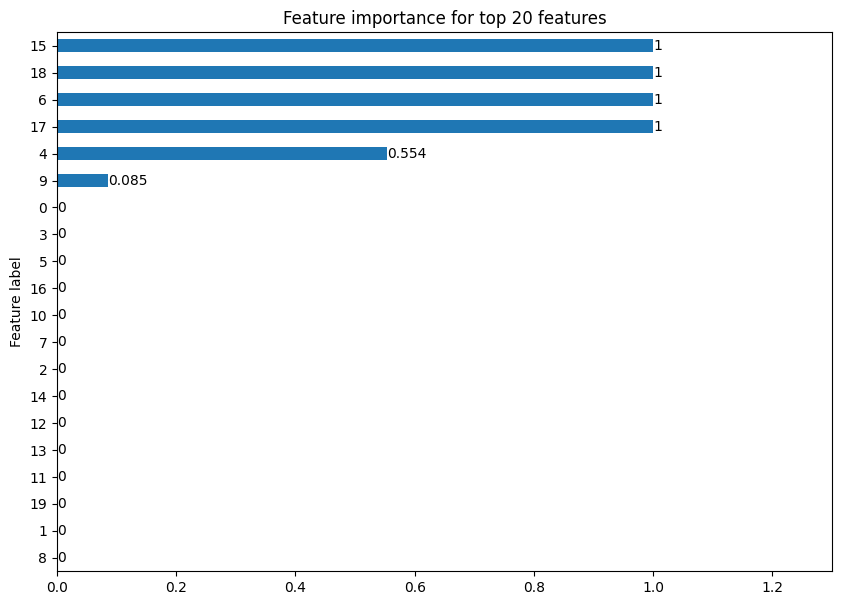

Explanation for graph tsnAIV_Mod.3.pdb_aligned: tensor([4.2658e-11, 0.0000e+00, 0.0000e+00, 4.2221e-11, 0.0000e+00, 0.0000e+00,
        4.2374e-11, 0.0000e+00, 4.2342e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        4.4669e-11, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

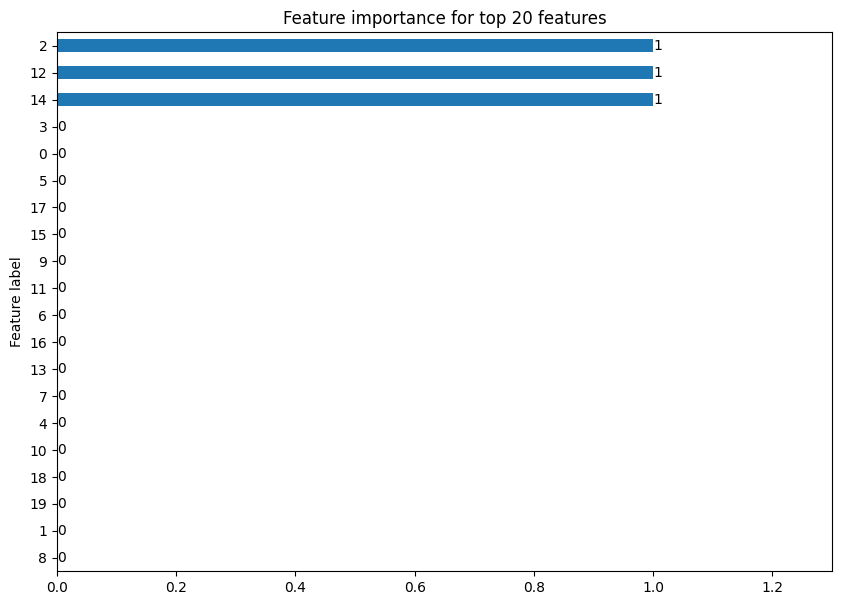

Explanation for graph natA_Mod.3.pdb_aligned: tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

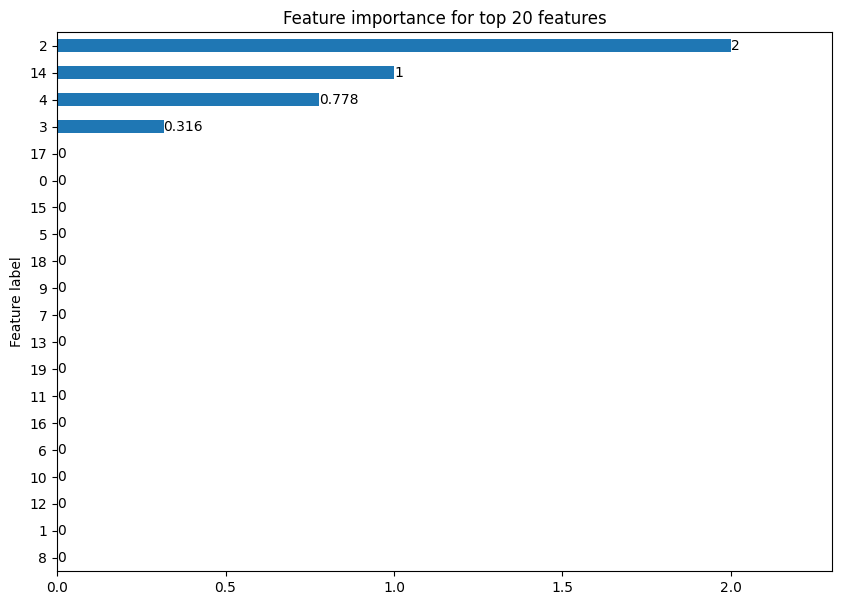

Explanation for graph angAI_Mod.1.pdb_aligned: tensor([4.2923e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 8.6697e-11, 0.0000e+00, 0.0000e+00, 8.2639e-11, 4.2873e-11,
        0.0000e+00, 4.4511e-11, 4.2767e-11, 0.0000e+00, 4.4243e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

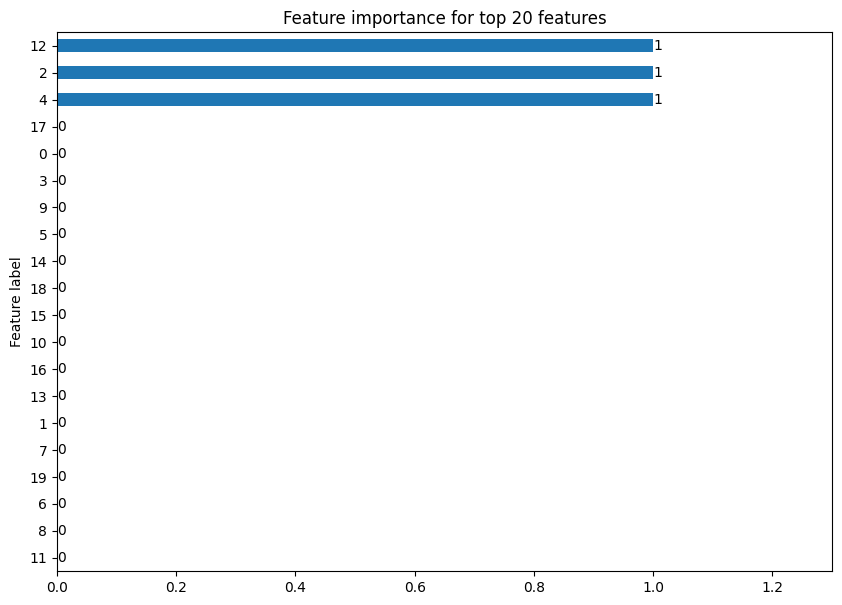

Explanation for graph tsnAII_Mod.1.pdb_aligned: tensor([4.1474e-11, 0.0000e+00, 0.0000e+00, 4.1027e-11, 0.0000e+00, 4.1220e-11,
        0.0000e+00, 4.1250e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 4.0834e-11, 4.3281e-11,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

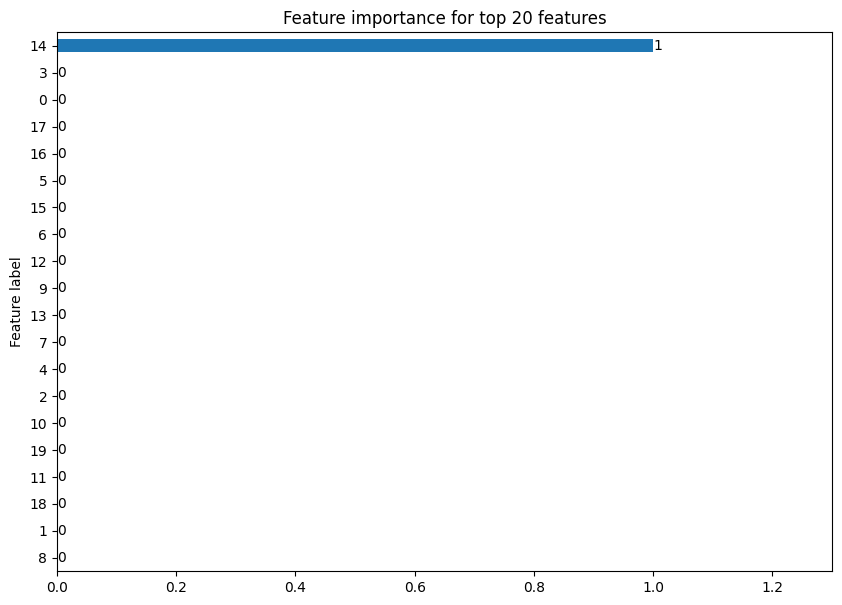

Explanation for graph fscD_Mod.3.pdb_aligned: tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 3.1959e-11,
        0.0000e+00, 2.4273e-11, 3.2138e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000

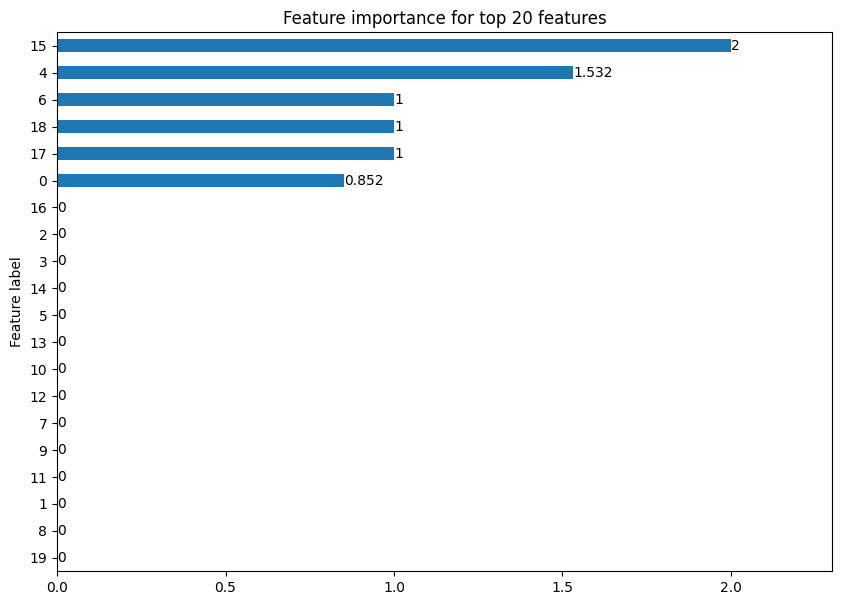

Explanation for graph tmnAV_Mod.3.pdb_aligned: tensor([3.8622e-11, 0.0000e+00, 0.0000e+00, 3.8111e-11, 0.0000e+00, 3.8326e-11,
        0.0000e+00, 3.8336e-11, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 4.1054e-11, 0.0000e+00,
        4.0850e-11, 2.3660e-01, 0.0000e+00, 3.8215e-11, 3.8280e-11, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000

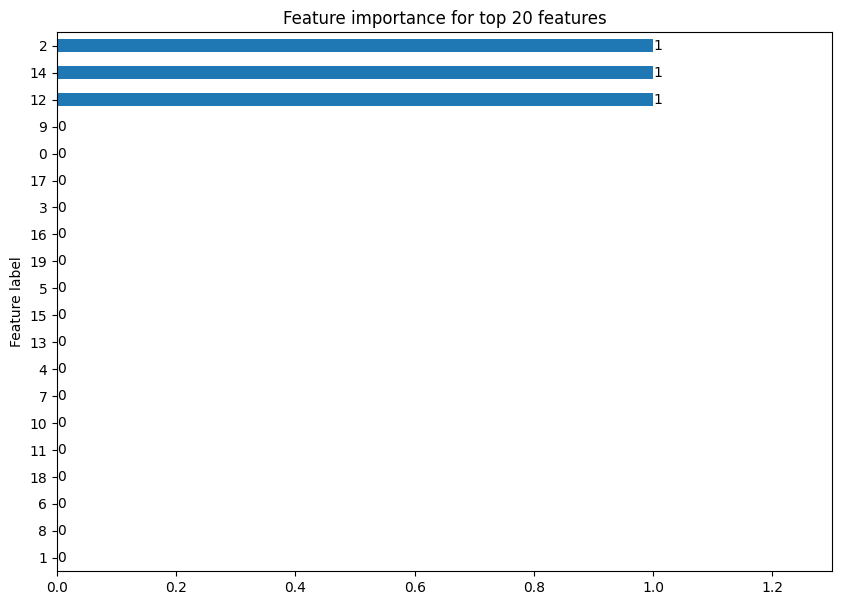

In [59]:
### Explainer loop ###

import os

# Specify the folder where you want to save the output files
output_folder = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20240131_AT_graphViz/"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through your loader
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100000),
    explanation_type='phenomenon', # options are model (describes the model) or phenomenon (describes why descision was made for input and input label)
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw', 
    ),
)
# Iterate through your loader
loader = test_loader
for batch in loader:
    # Print some information about the current batch
    print(f"Processing batch with {batch.num_graphs} graphs")

    # Generate explanation for each graph in the batch
    for i in range(batch.num_graphs):
        # Extract data for the i-th graph in the batch
        graph_data = batch[i]

        # Create a new Data object
        data = Data(
            edge_index=graph_data.edge_index,
            node_id=graph_data.node_id,
            coords=graph_data.coords,
            name=graph_data.name,
            num_nodes=graph_data.num_nodes,
            x=graph_data.x.view(len(graph_data.node_id), 20),
        )

        # Extract the graph-level label for the current graph
        target_values = graph_data.graph_y.tolist()
        target = torch.tensor(target_values).long()

        # Generate explanation for the node at index `10`:
        explanation = explainer(x=data.x, edge_index=data.edge_index, batch=data.batch, target=target)

        # Print or do something with the explanation for the current graph
        print(f"Explanation for graph {graph_data.name}:", explanation.edge_mask, explanation.node_mask)

        # Optionally, you can visualize the feature importance for each graph
        explanation.visualize_feature_importance(top_k=20)

        # Save the output of visualize_graph to a file in the specified folder
        graphviz_output = explanation.visualize_graph(path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"), backend="graphviz")



In [8]:
import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
import pandas as pd

# Snake Loader
snakes_route = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/Aligned_AT_SNAKES_mixed/"
#snakes_route = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20231011_Gen2_SNAKES_r1_aligned_combined/"
#snakes_route = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/test_file/"
#snakes_route = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/test_file_mal/"

filenames = os.listdir(snakes_route)
absolute_file_paths_snakes = [os.path.join(snakes_route, filename) for filename in filenames]

# Create the dataset with graph_labels as a list of tensors
# (Make sure you've imported all the necessary modules for ProteinGraphDataset)
dataset_snakes = ProteinGraphDataset(
    #root='/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20231012_AT_graphs_Ca_balanced_k_nearest_SNAKES', 
    root='/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/test_graph', 
    paths=absolute_file_paths_snakes,
    graphein_config=config, 
    graph_format_convertor=convertor,
    num_cores=7
)

# Define your custom Data class with __cat_dim__ method
class MyData(Data):
    def __cat_dim__(self, key, value, *args, **kwargs):
        if key == 'graph_y':
            return None  # Indicates that 'graph_y' should be batched along a new dimension
        return super().__cat_dim__(key, value, *args, **kwargs)

# Create a list of Data objects, ensuring 'graph_y' is a 2D tensor [num_examples, num_labels]
# Initialize an empty list to store the modified Data objects
data_list_snakes = []

# Iterate through your existing ProteinGraphDataset
for graph in dataset_snakes:
    # Create a new Data object
    data = Data(
        edge_index=graph.edge_index, 
        node_id=graph.node_id,
        coords=graph.coords, 
        name=graph.name,
        num_nodes=graph.num_nodes,
        x=graph.amino_acid_one_hot.view(len(graph.node_id), 20),
    )
    # Append the modified Data object to the list
    data_list_snakes.append(data)

snake_loader = DataLoader(data_list_snakes, batch_size=batch_size)

# Assuming you have already defined and trained your model as 'model'
model.eval()

# Initialize a list to store predictions
predictions = []

# ...
with torch.no_grad():
    for batch in snake_loader:
        batch = batch.to(device)  # Move the batch to the appropriate device (CPU or GPU)
        out = model(batch.x, batch.edge_index, batch.batch) # Forward pass
        
        # Convert the model's output to predictions
        predicted_probs = torch.softmax(out, dim=1)  # Compute class probabilities
        predicted_labels = predicted_probs.argmax(dim=1)  # Get the index of the maximum probability
        
        # Append the predictions to the list
        predictions.append(predicted_probs.cpu().numpy())
# ...


# Concatenate predictions from different batches into a single numpy array
predictions = np.concatenate(predictions)

print("Number of predictions:", len(predictions))
print("Number of snakes:", len(absolute_file_paths_snakes))


import numpy as np
import pandas as pd
import re

# Assuming you have already obtained 'predictions' and 'absolute_file_paths_snakes'

# Split the 'predictions' tensor into two columns
class_0_probs = predictions[:, 0]  # Probability for class 0
class_1_probs = predictions[:, 1]  # Probability for class 1

# Create a DataFrame with the split columns
data = {
    'Class 0 Probability': class_0_probs,
    'Class 1 Probability': class_1_probs,
    'File Paths': [re.match(r'(.+)\.', os.path.splitext(os.path.basename(path))[0]).group(1) for path in absolute_file_paths_snakes]
}

df = pd.DataFrame(data)

# Display the DataFrame (optional)
print(df)

df_sorted = df.sort_values(by='File Paths')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(df_sorted)
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')


result_df = df_sorted

# Iterate through the rows
for index, row in df.iterrows():
    file_path = row['File Paths']
    # Check if the current row contains "SNAKE"
    if 'SNAKE' in file_path:
        # Find the corresponding row without "SNAKE"
        corresponding_row = df[df['File Paths'] == file_path.replace('_SNAKE', '')]
        # Check if a corresponding row exists
        if not corresponding_row.empty:
            # Subtract the corresponding row's index from the current row's index
            subtraction_result = index - corresponding_row.index[0]
            # Append the result to the new DataFrame
            result_df = result_df.append({'File Paths': file_path, 'Subtraction Result': subtraction_result}, ignore_index=True)

# Display the result DataFrame
print(result_df)

Number of predictions: 78
Number of snakes: 78
    Class 0 Probability  Class 1 Probability                  File Paths
0              0.312292             0.687708   nbrL_Mod.2_was_mmal_SNAKE
1              0.926111             0.073889              ladSVIII_Mod.1
2              0.015309             0.984691                  fscD_Mod.1
3              0.026332             0.973668                  revC_Mod.2
4              0.032244             0.967756    idmM_Mod.1_was_mal_SNAKE
..                  ...                  ...                         ...
73             0.017514             0.982486                  fscC_Mod.4
74             0.031593             0.968407  tsnAIV_Mod.1_was_mal_SNAKE
75             0.467830             0.532170   rapB_Mod.6_was_mmal_SNAKE
76             0.298398             0.701602  nanA1_Mod.2_was_mmal_SNAKE
77             0.291800             0.708200  nanA8_Mod.2_was_mmal_SNAKE

[78 rows x 3 columns]
    Class 0 Probability  Class 1 Probability          

In [6]:
## Graph Attention network ## 

### This version's model takes in tensors instead of "data". This is needed to talk to the graph explainer. ###
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_max_pool
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set seed
torch.manual_seed(15706112877486103401)

# Network parameters
input_dim = 20  # Corresponds to amino acid OHE
hidden_dim = 64
output_dim = 2  # Output dimension for binary classification.

# Hyperparameters
num_epochs = 20
learning_rate = 0.001

# Define a GAT model
class MyGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super(MyGAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
        self.lin = Linear(hidden_dim * num_heads, output_dim)

    def forward(self, x, edge_index, batch):
        # Convert input tensor 'x' to Float data type
        x = x.float()
        
        # Apply the first graph attention layer
        x = self.conv1(x, edge_index)
        x = x.relu()
    
        # Apply the second graph attention layer
        x = self.conv2(x, edge_index)
        x = x.relu()
    
        # Perform graph-level pooling (e.g., global max pooling)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        x = torch.relu(x)  # Sigmoid activation for binary classification
    
        return x


# Initialize your GNN model
model = MyGAT(input_dim, hidden_dim, output_dim)

# Assuming you have a batch of data from the DataLoader (modify this according to your actual data loading)
batch = next(iter(train_loader))
print(batch)

# Forward pass through the model
out = model(batch.x, batch.edge_index, batch.batch)


# Define optimization method
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# empty containers for loss and accuracy metrics #
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []


## Training and validation loops ## 
for epoch in range(num_epochs):
    epoch_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0
    
    # Training loop
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Provide the necessary arguments to the model's forward method
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        loss = F.cross_entropy(out, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

        predicted_labels = out.argmax(dim=1)
        total_correct_train += (predicted_labels == labels).sum().item()
        total_samples_train += labels.size(0)
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Calculate training accuracy
    train_accuracy = accuracy_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())    
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    total_correct_val = 0
    total_samples_val = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)  # Provide the necessary arguments
            
            labels = (batch.graph_y[:, 0] == 1).long()
            
            loss = F.cross_entropy(out, labels)
            val_loss += loss.item()
            
            predicted_labels = out.argmax(dim=1)
            total_correct_val += (predicted_labels == labels).sum().item()
            total_samples_val += labels.size(0)

    
    
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    # Compute the number of correct predictions    
    val_accuracy = accuracy_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())    
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")


# Plotting the training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train accuracy', color='blue')
plt.plot(val_accuracies, label='Validation accuracy', color='orange')  # Add this line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished!")

#Good seeds!:
#15706112877486103401?


### Test data ###
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score

# Assuming you have your test data in a DataLoader called test_loader
# If you don't have one, create it similarly to how you created train_loader and val_loader.

# Set the model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
total_correct_test = 0
total_samples_test = 0

# Lists to store predictions and true labels for potential further analysis
test_predictions = []
test_labels = []

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)  # Send data to GPU if available
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Calculate predictions
        predicted_labels = out.argmax(dim=1)
        
        # Accumulate the number of correct predictions and total samples
        total_correct_test += (predicted_labels == labels).sum().item()
        total_samples_test += labels.size(0)

        # Store predictions and true labels
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)

# Report the test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")






DataBatch(x=[18696, 20], edge_index=[2, 32297], node_id=[64], coords=[18696, 3], name=[64], num_nodes=18696, graph_y=[64, 2], batch=[18696], ptr=[65])
Epoch [1/20] - Train Loss: 0.6859 - Train Accuracy: 0.5000 - Validation Loss: 0.6717 - Validation Accuracy: 0.6129
Epoch [2/20] - Train Loss: 0.6630 - Train Accuracy: 0.9524 - Validation Loss: 0.6466 - Validation Accuracy: 0.9839
Epoch [3/20] - Train Loss: 0.6355 - Train Accuracy: 0.9286 - Validation Loss: 0.6113 - Validation Accuracy: 1.0000


KeyboardInterrupt: 